In [ ]:
# ============================================================
# üì¶ ‰∏ãËºâËàáÊï¥ÁêÜË≥áÊñôÈõÜÔºàOULADÔºâ
# ============================================================

import kagglehub
import shutil
import os

# 1Ô∏è‚É£ Âæû Kaggle Hub ‰∏ãËºâÊúÄÊñ∞ÁâàÊú¨Ë≥áÊñôÈõÜÔºàËá™ÂãïÂø´ÂèñÔºâ
path = kagglehub.dataset_download(
    "anlgrbz/student-demographics-online-education-dataoulad"
)
print("Path to dataset files:", path)

# 2Ô∏è‚É£ ÊåáÂÆöÊê¨ÁßªÁõÆÁöÑÂú∞
dest_dir = "./download_data"
os.makedirs(dest_dir, exist_ok=True)

# 3Ô∏è‚É£ Êê¨ÁßªÊâÄÊúâ CSV Ê™îÊ°àÂà∞Êú¨Âú∞Ë≥áÊñôÂ§æÔºàÊñπ‰æøÁµ±‰∏ÄÂ≠òÂèñÔºâ
for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dest_file = os.path.join(dest_dir, filename)
    if os.path.isfile(src_file):
        shutil.copy2(src_file, dest_file)

print(f"‚úÖ Dataset files moved to: {os.path.abspath(dest_dir)}")


/mnt/hgfs/shared_folder/summer_study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/guoyouuu/.cache/kagglehub/datasets/anlgrbz/student-demographics-online-education-dataoulad/versions/1
‚úÖ Dataset files moved to: /mnt/hgfs/shared_folder/summer_study/src/download_data


In [ ]:
import os
import random
import numpy as np
import torch

# ============================================================
# üîß ÂÖ®ÂüüË®≠ÂÆöÔºàGlobal SettingsÔºâ
# ============================================================
EPOCHS = 100
SEED = 42

# ÂïüÁî®Â§öÊ†∏ÂøÉÔºàÊúÄÂ§ö 16 threadsÔºâ
torch.set_num_threads(min(16, os.cpu_count() or 1))
print(f"‰ΩøÁî® CPU threads: {torch.get_num_threads()}")

# Âõ∫ÂÆöÈö®Ê©üÁ®ÆÂ≠êÔºàÁ¢∫‰øùÁµêÊûúÂèØÈáçÁèæÔºâ
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Ë£ùÁΩÆË®≠ÂÆöÔºàËá™ÂãïÂÅµÊ∏¨ GPU / CPUÔºâ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("‰ΩøÁî®Ë£ùÁΩÆ:", device)
print(f"PyTorch ÁâàÊú¨: {torch.__version__}")

# ============================================================
# ‚öôÔ∏è Ê®°ÂûãËàáË≥áÊñôÂèÉÊï∏Ë®≠ÂÆö
# ============================================================
T_IN, T_OUT = 4, 2           # Encoder/Decoder ÊôÇÈñìÈï∑Â∫¶
HIDDEN_DIM, NUM_LAYERS = 64, 1
LATENT_DIM = 16               # VAE ÊΩõÂú®Á∂≠Â∫¶
LR, BATCH_SIZE = 1e-3, 128
BETA, TEACHER_FORCING = 2, 0.5
VAE_SAMPLE_N, COVERAGE_ALPHA = 20, 1.0

# ÁâπÂæµË®≠ÂÆö
FEATURES = ["clicks", "submit_cnt", "has_submit", "avg_score_sofar", "clicks_diff1"]
CONT_FEATURES = ["clicks", "submit_cnt", "avg_score_sofar", "clicks_diff1"]
BIN_FEATURES = ["has_submit"]
D_IN = len(FEATURES)



‰ΩøÁî® CPU threads: 16
‰ΩøÁî®Ë£ùÁΩÆ: cpu
PyTorch ÁâàÊú¨: 2.8.0+cu128


In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# üß± 1) ËÆÄÂèñÂéüÂßãË≥áÊñô
#   - ‰∏âÂÄã‰æÜÊ∫êÔºöÂ≠∏ÁîüÈùúÊÖãË≥áÊñô„ÄÅÁ∑ö‰∏äÂ≠∏ÁøíÈªûÊìäÁ¥ÄÈåÑ„ÄÅ‰ΩúÊ•≠ÊàêÁ∏æ/Êèê‰∫§
# ============================================================
PATH_INFO   = "./download_data/studentInfo.csv"
PATH_VLE    = "./download_data/studentVle.csv"
PATH_ASSESS = "./download_data/studentAssessment.csv"

info = pd.read_csv(PATH_INFO)
vle  = pd.read_csv(PATH_VLE)
ass  = pd.read_csv(PATH_ASSESS)

# ============================================================
# üß© 2) Ë£úÈΩäÊ¨Ñ‰Ωç / Ê∏ÖÁêÜÊó•Êúü
#   - assessment Ê™îÊ≤íÊúâ module/presentation ‚Üí Âæû info ‰æù id_student Ë£ú‰∏ä
#   - ÁßªÈô§ date<0ÔºöÈÅøÂÖçÁî¢ÁîüË≤†ÈÄ±Êï∏ÔºàË™≤Á®ãÂâçÁöÑÁ≥ªÁµ±Ë®òÈåÑ‰∏çÁ¥çÂÖ•Ôºâ
# ============================================================
ass = ass.merge(
    info[["code_module", "code_presentation", "id_student"]],
    on="id_student", how="left"
)
vle = vle[vle["date"] >= 0].copy()
ass = ass[ass["date_submitted"] >= 0].copy()

# ============================================================
# üìÜ 3) ËΩâÊàê„ÄåÈÄ±„ÄçÁÇ∫ÊôÇÈñìÂñÆ‰Ωç
#   - OULAD ÁöÑ date ÁÇ∫Ë™≤Á®ãÊó•Êï∏ÔºàÂæûÈñãË™≤Êó• 0 Ëµ∑ÁÆóÔºâÔºå‰ª• //7 Â£ìÊàêÈÄ±
#   - Â•ΩËôïÔºöÈôçÂô™„ÄÅËàá‰ΩúÊ•≠ T_IN=4 / T_OUT=2 ÁöÑÈÄ±Á¥öÈ†êÊ∏¨Â∞∫Â∫¶‰∏ÄËá¥
# ============================================================
vle["week"] = (vle["date"] // 7).astype(int)
ass["week"] = (ass["date_submitted"] // 7).astype(int)

# ============================================================
# üìä 4) ÈÄ±Á¥öÁâπÂæµËÅöÂêà
#   (a) clicksÔºöÂêå‰∏ÄÂ≠∏Áîü/ÈÄ±ÁöÑ sum_click Âä†Á∏Ω
#   (b) submit_cnt / has_submitÔºöË©≤ÈÄ±Êèê‰∫§‰ΩúÊ•≠Ê¨°Êï∏ËàáÊòØÂê¶ÊúâÊèê‰∫§
#   (c) avg_score_sofarÔºöËá≥Ë©≤ÈÄ±ÁöÑ„ÄåÁ¥ØÁ©çÂπ≥ÂùáÂàÜÊï∏„ÄçÔºàËÄÉÊÖÆÊôÇÈñìÈ†ÜÂ∫èÔºâ
# ============================================================

# (a) ÊØèÈÄ±ÈªûÊìäÊï∏
clicks_w = (
    vle.groupby(["code_module","code_presentation","id_student","week"])["sum_click"]
       .sum()
       .rename("clicks")
       .reset_index()
)

# (b) ÊØèÈÄ±Êèê‰∫§Ê¨°Êï∏ËàáÊòØÂê¶Êèê‰∫§Ôºà>0Ôºâ
ass_w = (
    ass.groupby(["code_module","code_presentation","id_student","week"])["id_assessment"]
       .count()
       .rename("submit_cnt")
       .reset_index()
)
ass_w["has_submit"] = (ass_w["submit_cnt"] > 0).astype(int)

# (c) Á¥ØÁ©çÂπ≥ÂùáÂàÜÊï∏ÔºöÂÖà‰æùÊôÇÈñìÊéíÂ∫è ‚Üí ÂÜçÂÅöÂÄãÂà•Â≠∏ÁîüÁöÑÁ¥ØÁ©ç mean
ass_sc = ass.dropna(subset=["score"]).copy()
ass_sc.sort_values(["code_module","code_presentation","id_student","week"], inplace=True)
ass_sc["cum_sum"] = ass_sc.groupby(["code_module","code_presentation","id_student"])["score"].cumsum()
ass_sc["cum_cnt"] = ass_sc.groupby(["code_module","code_presentation","id_student"])["score"].cumcount() + 1
ass_sc["avg_score_sofar"] = ass_sc["cum_sum"] / ass_sc["cum_cnt"]

# ÂèñÂà∞„ÄåÊØèÈÄ±ÁöÑÊúÄÂæå‰∏ÄÊ¨°ÂèØÁî®Âπ≥Âùá„ÄçÁï∂ÈÄ±ÂÄºÔºàÈÅøÂÖçÂêåÈÄ±Â§öÊ¨°Êèê‰∫§ÈáçË§áÔºâ
score_w = (
    ass_sc.groupby(["code_module","code_presentation","id_student","week"])["avg_score_sofar"]
          .last()
          .reset_index()
)

# ============================================================
# üîó 5) Âêà‰ΩµÁâπÂæµÂà∞ÈÄ±Á¥öÈù¢Êùø (panel)
#   - Â∑¶ÈÄ£ infoÔºö‰øùÁïôÊâÄÊúâÂ≠∏ÁîüÂü∫Êú¨Ë≥áÊñôÔºàÊüê‰∫õÈÄ±Ê≤íÊúâ clicks/submit ‰πü‰∏ç‰∏üÔºâ
#   - ÂÜçÂ∑¶ÈÄ£ clicks/submit/score
#   - Áº∫ÂÄºËôïÁêÜÔºö
#       clicks, submit_cnt: 0ÔºàÊú™ÈªûÊìä/Êú™Êèê‰∫§Ôºâ
#       has_submit: 0ÔºàÂ∏ÉÊûóÔºâ
#       avg_score_sofar: ‰ª•Â≠∏ÁîüÁÇ∫ÂñÆ‰Ωç ffillÔºàÈñãÈ†≠‰ªçÁº∫Â∞±Â°´ 0Ôºâ
# ============================================================
weekly = info.merge(clicks_w, on=["code_module","code_presentation","id_student"], how="left")
weekly = weekly.merge(ass_w,   on=["code_module","code_presentation","id_student","week"], how="left")
weekly = weekly.merge(score_w, on=["code_module","code_presentation","id_student","week"], how="left")

weekly["clicks"]      = weekly["clicks"].fillna(0.0)
weekly["submit_cnt"]  = weekly["submit_cnt"].fillna(0.0)
weekly["has_submit"]  = weekly["has_submit"].fillna(0).astype(int)
weekly["avg_score_sofar"] = (
    weekly.groupby(["code_module","code_presentation","id_student"])["avg_score_sofar"]
          .ffill()           # Âè™Âú®„ÄåÂêå‰∏ÄÂ≠∏Áîü„ÄçÂÖßÂêëÂâçÂ∏∂
          .fillna(0.0)       # ‰∫∫ÁîüÁ¨¨‰∏ÄÁ≠Ü‰ªçÊ≤íÊúâÂàÜÊï∏ ‚Üí 0
)

# ============================================================
# üßÆ 6) Ë£úÈΩäÊØè‰ΩçÂ≠∏ÁîüÁöÑ„ÄåÈÄ£Á∫åÈÄ±„ÄçÁ¥¢ÂºïÔºå‰∏¶ÂÅö‰∏ÄÈöéÂ∑ÆÂàÜ
#   - Êúâ‰∫õÂ≠∏ÁîüÊüê‰∫õÈÄ±ÂÆåÂÖ®Ê≤íË°åÁÇ∫ ‚Üí ÈúÄË¶ÅË£ú 0 ËÆìÂ∫èÂàóÈÄ£Á∫å
#   - clicks_diff1: ‰∏ÄÈöéÂ∑ÆÂàÜÔºàÂãïÈáè/Âä†ÈÄüÂ∫¶Ë®äËôüÔºâÔºå‰æõÊ®°ÂûãÂ≠∏ÁøíËÆäÂåñÁéá
#   - Âè™‰øùÁïôÈï∑Â∫¶ >= T_IN + T_OUT ÁöÑÂ≠∏ÁîüÔºàÂ§†ÂàáÁâáÊâçËÉΩÊäΩÊ®£Ë®ìÁ∑¥Ôºâ
# ============================================================
def build_student_week_table(df):
    df = df.dropna(subset=["week"])
    if len(df) == 0:
        return pd.DataFrame(columns=["week","clicks","submit_cnt","has_submit","avg_score_sofar","clicks_diff1"])

    wmin, wmax = int(df["week"].min()), int(df["week"].max())
    # ÁîüÊàêÈÄ£Á∫åÈÄ±Á¥¢ÂºïÂæåÂ∑¶ÈÄ£ÔºåÁº∫ÁöÑÂ°´ 0
    full = pd.DataFrame({"week": np.arange(wmin, wmax + 1, dtype=int)})
    full = full.merge(
        df[["week","clicks","submit_cnt","has_submit","avg_score_sofar"]],
        on="week", how="left"
    ).fillna(0.0)

    # ÈÄ±ÈªûÊìäÁöÑ‰∏ÄÈöéÂ∑ÆÂàÜÔºàÁ¨¨ 1 ÈÄ±Â∑ÆÂàÜÂÆöÁæ©ÁÇ∫ 0Ôºâ
    full["clicks_diff1"] = full["clicks"].diff().fillna(0.0)
    return full.reset_index(drop=True)

grp_keys = ["code_module","code_presentation","id_student"]
student_tables = {}
for k, g in weekly.groupby(grp_keys, sort=False):
    tbl = build_student_week_table(g)
    if len(tbl) >= (T_IN + T_OUT):
        student_tables[k] = tbl

print(f"‚úÖ ÂÖ± {len(student_tables)} ‰ΩçÂ≠∏ÁîüÂÖ∑Ë∂≥Â§†ÈÄ±Êï∏Ë≥áÊñô")


‚úÖ ÂÖ± 25146 ‰ΩçÂ≠∏ÁîüÂÖ∑Ë∂≥Â§†ÈÄ±Êï∏Ë≥áÊñô


In [ ]:
from sklearn.model_selection import train_test_split

# ============================================================
# üß≠ 1. Ë≥áÊñôÂàáÂàÜÔºàTrain / Val / TestÔºâ
# ============================================================
# train : val : test ‚âà 70 : 15 : 15
ids = list(student_tables.keys())
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=SEED)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.1765, random_state=SEED)
print(f"train/val/test = {len(train_ids)}/{len(val_ids)}/{len(test_ids)}")

# ============================================================
# ‚öñÔ∏è 2. ‰ª•Ë®ìÁ∑¥ÈõÜÁµ±Ë®àÈáèÈÄ≤Ë°åÊ®ôÊ∫ñÂåñÔºàStandardizationÔºâ
# ============================================================
def fit_transform_standardize(student_tables, train_ids, cont_cols):
    """
    ‰ª• train set ÁöÑÂ≠∏ÁîüË≥áÊñô‰º∞Ë®àÂêÑÈÄ£Á∫åÁâπÂæµÁöÑ Œº / œÉÔºå
    ‰∏¶Â∞çÊâÄÊúâÂ≠∏ÁîüÁöÑÁâπÂæµÔºàÂê´È©óË≠âËàáÊ∏¨Ë©¶ÔºâÂÅöÊ®ôÊ∫ñÂåñ„ÄÇ
    """
    # Êî∂ÈõÜÊâÄÊúâË®ìÁ∑¥Â≠∏ÁîüÁöÑÈÄ£Á∫åÊ¨Ñ‰Ωç
    train_concat = pd.concat([student_tables[k][cont_cols] for k in train_ids], axis=0)
    mu = train_concat.mean(axis=0)
    sd = train_concat.std(axis=0).replace(0, 1e-8)  # Èò≤Ê≠¢Èô§‰ª•Èõ∂

    # Â•óÁî® (x - Œº) / œÉ ËΩâÊèõÂà∞ÊâÄÊúâÂ≠∏Áîü
    for k in student_tables:
        for col in cont_cols:
            student_tables[k][col] = (student_tables[k][col] - mu[col]) / sd[col]
    return mu.to_dict(), sd.to_dict()

# Âü∑Ë°åÊ®ôÊ∫ñÂåñÔºà‰∏¶‰øùÁïô clicks ÁöÑ Œº„ÄÅœÉ ‰ª•‰æøÂæåÁ∫åÂèçÊ®ôÊ∫ñÂåñÔºâ
mu, sd = fit_transform_standardize(student_tables, train_ids, CONT_FEATURES)
CLICK_MU, CLICK_SD = mu["clicks"], sd["clicks"]

print("‚úÖ Ê®ôÊ∫ñÂåñÂÆåÊàêÔºà‰ª• train ÁÇ∫Âü∫Ê∫ñÔºõÂæåÁ∫åË©ï‰º∞ÊúÉÂèçÊ®ôÊ∫ñÂåñ clicksÔºâ")


train/val/test = 17601/3773/3772
‚úÖ Ê®ôÊ∫ñÂåñÂÆåÊàêÔºà‰ª• train ÁÇ∫Âü∫Ê∫ñÔºõÂæåÁ∫åË©ï‰º∞ÊúÉÂèçÊ®ôÊ∫ñÂåñ clicksÔºâ


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# ============================================================
# üì¶ Ëá™Ë®Ç DatasetÔºöÂª∫Á´ã (X, Y) ÊôÇÈñìÂ∫èÂàóÊ®£Êú¨
# ============================================================
class StudentSeqDataset(Dataset):
    def __init__(self, student_tables, ids, T_IN, T_OUT, features):
        """
        student_tables : dictÔºåÊØè‰ΩçÂ≠∏ÁîüÁöÑ weekly ÁâπÂæµË≥áÊñôË°®
        ids : listÔºåÂåÖÂê´Ë©≤Ë≥áÊñôÈõÜÔºàtrain/val/testÔºâÁöÑÂ≠∏ÁîüÁ¥¢ÂºïÈçµ
        T_IN : intÔºåËº∏ÂÖ•Â∫èÂàóÈï∑Â∫¶ÔºàEncoder ‰ΩøÁî®ÁöÑÈÅéÂéªÈÄ±Êï∏Ôºâ
        T_OUT : intÔºåËº∏Âá∫Â∫èÂàóÈï∑Â∫¶ÔºàDecoder È†êÊ∏¨ÁöÑÊú™‰æÜÈÄ±Êï∏Ôºâ
        features : list[str]Ôºå‰ΩúÁÇ∫Ê®°ÂûãËº∏ÂÖ•ÁöÑÊ¨Ñ‰ΩçÂêçÁ®±
        """
        self.samples = []
        for sid in ids:
            tbl = student_tables[sid]
            x_all = tbl[features].values.astype(np.float32)                 # (W, D_IN)
            y_all = tbl["clicks"].values.astype(np.float32).reshape(-1, 1)  # (W, 1)
            W = len(tbl)

            # Âª∫Á´ãÊªëÂãïË¶ñÁ™óÊ®£Êú¨ÔºöÊØèÂÄãÂ≠∏ÁîüÁöÑÂ∫èÂàóÈÉΩÊúÉÁîüÊàêÂ§öÁ≠Ü (X, Y)
            for t in range(T_IN - 1, W - T_OUT):
                x = x_all[t - T_IN + 1 : t + 1]       # Encoder Ëº∏ÂÖ•ÔºöÈÅéÂéª T_IN ÈÄ±
                y = y_all[t + 1 : t + 1 + T_OUT]     # Decoder Ëº∏Âá∫ÔºöÊú™‰æÜ T_OUT ÈÄ±
                self.samples.append((x, y))

    def __len__(self):
        """ÂõûÂÇ≥Ê®£Êú¨Á∏ΩÊï∏ÔºàÊâÄÊúâÂ≠∏ÁîüÂ±ïÈñãÂæåÁöÑÊï∏ÈáèÔºâ"""
        return len(self.samples)

    def __getitem__(self, idx):
        """ÂèñÂá∫Á¨¨ idx Á≠ÜÊ®£Êú¨ÔºåËΩâÁÇ∫ torch.Tensor"""
        x, y = self.samples[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# ============================================================
# üîÑ Âª∫Á´ã Dataset Ëàá DataLoader
# ============================================================
train_ds = StudentSeqDataset(student_tables, train_ids, T_IN, T_OUT, FEATURES)
val_ds   = StudentSeqDataset(student_tables, val_ids,   T_IN, T_OUT, FEATURES)
test_ds  = StudentSeqDataset(student_tables, test_ids,  T_IN, T_OUT, FEATURES)

# DataLoaderÔºöË≤†Ë≤¨ batch ÂåñËàá shuffle
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train: 428270 | Val: 91664 | Test: 91566


# Seq2Seq LSTM ÈÇèËºØÊµÅÁ®ãÔºàÊ®°ÂûãË©≥Ëß£ÁâàÔºâ

---

## 1. ÂïèÈ°åËÉåÊôØ

* **‰ªªÂãôÁõÆÊ®ô**ÔºöÊôÇÈñìÂ∫èÂàóÈ†êÊ∏¨ÔºàSequence-to-Sequence PredictionÔºâ„ÄÇ
  Ê®°ÂûãËßÄÂØüÈÅéÂéª‰∏ÄÊÆµÊôÇÈñìÁöÑË°åÁÇ∫Â∫èÂàóÔºåÂ≠∏ÁøíÂÖ∂‰∏≠ÁöÑËÆäÂåñË¶èÂæãÔºå
  ÈÄ≤ËÄåÈ†êÊ∏¨Êú™‰æÜ‰∏ÄÊÆµÊôÇÈñìÁöÑË°åÁÇ∫Ëµ∞Âêë„ÄÇ

* **ÊáâÁî®Â†¥ÊôØ**Ôºö
  ÊàëÂÄë‰ΩøÁî®Â≠∏ÁîüÂú®Â≠∏ÁøíÂπ≥Âè∞‰∏äÁöÑË°åÁÇ∫Ë≥áÊñô‰ΩúÁÇ∫‰æãÂ≠ê„ÄÇ
  Ê®°ÂûãËº∏ÂÖ•Ôºö

  * ÈÅéÂéª **4 ÈÄ±** ÁöÑÁâπÂæµÔºàÂ¶Ç clicks„ÄÅ‰ΩúÊ•≠Êï∏„ÄÅÂπ≥ÂùáÂàÜÊï∏Á≠âÔºâ
    Ê®°ÂûãËº∏Âá∫Ôºö
  * Êú™‰æÜ **2 ÈÄ±** ÁöÑ `clicks` È†êÊ∏¨ÂÄº„ÄÇ

* **Ê†∏ÂøÉÊÄùÊÉ≥**Ôºö
  ÂÇ≥Áµ±ÁöÑ RNN Èõ£‰ª•Ë®ò‰ΩèÈï∑ÊúüÈóú‰øÇÔºàÊúÉ„ÄåÈÅ∫ÂøòÂâçÂπæÈÄ±„ÄçÔºâÔºå
  ËÄå LSTMÔºàÈï∑Áü≠ÊúüË®òÊÜ∂ÔºâËÉΩÂêåÊôÇ‰øùÁïôÁü≠ÊúüËàáÈï∑ÊúüË≥áË®ä„ÄÇ
  Âú® **Seq2Seq Êû∂Êßã** ‰∏≠ÔºåÊàëÂÄëÊää LSTM ÊãÜÊàêÂÖ©ÈÉ®ÂàÜÔºö

  * **Encoder**ÔºöÂ∞àÈñÄ„ÄåËÆÄÂèñÈÅéÂéª„Äç
  * **Decoder**ÔºöÂ∞àÈñÄ„ÄåÁîüÊàêÊú™‰æÜ„Äç

---

## 2. Ë≥áÊñôÊµÅËàáÁ∂≠Â∫¶

### Ëº∏ÂÖ•ËàáËº∏Âá∫

| ÂêçÁ®±                     | ÊÑèÁæ©             | ÂºµÈáèÂΩ¢ÁãÄ                |
| ---------------------- | -------------- | ------------------- |
| **Encoder input (X)**  | ÈÅéÂéª 4 ÈÄ±ÁöÑÊâÄÊúâÁâπÂæµ    | (B, T_in=4, D_in=5) |
| **Decoder output (Y)** | Êú™‰æÜ 2 ÈÄ±ÁöÑ clicks | (B, T_out=2, 1)     |

ÂÖ∂‰∏≠Ôºö

* **B**Ôºö‰∏ÄÊ¨°Ë®ìÁ∑¥ÊâπÊ¨°‰∏≠ÊúâÂ§öÂ∞ëÂ≠∏Áîü
* **T_in**ÔºöËº∏ÂÖ•ÊôÇÈñìÈï∑Â∫¶Ôºà4 ÈÄ±Ôºâ
* **D_in**ÔºöÊØèÈÄ±ÁâπÂæµÊï∏Ôºà5 ÂÄãÔºâ
* **T_out**ÔºöË¶ÅÈ†êÊ∏¨ÁöÑÊôÇÈñìÈï∑Â∫¶Ôºà2 ÈÄ±Ôºâ

ÁØÑ‰æãÔºö

> Â∞çÊüêÂÄãÂ≠∏Áîü‰æÜË™™ÔºåÊ®°ÂûãËº∏ÂÖ•Ôºö
>
> ```
> Á¨¨1ÈÄ±: [clicks=50, submit=1, has_submit=1, avg_score=60, diff=0]
> Á¨¨2ÈÄ±: [clicks=40, submit=0, has_submit=0, avg_score=60, diff=-10]
> Á¨¨3ÈÄ±: [clicks=80, submit=2, has_submit=1, avg_score=70, diff=40]
> Á¨¨4ÈÄ±: [clicks=100, submit=1, has_submit=1, avg_score=75, diff=20]
> ```
>
> Ê®°ÂûãË¶ÅÈ†êÊ∏¨Ôºö
>
> ```
> Á¨¨5ÈÄ±„ÄÅÁ¨¨6ÈÄ±ÁöÑ clicks Êï∏„ÄÇ
> ```

---

## 3. Ê®°ÂûãÁµêÊßã

Seq2Seq LSTM Áî±ÂÖ©ÂÄã‰∏ªË¶ÅÈÉ®ÂàÜÁµÑÊàêÔºö

---

### (1) EncoderÔºöËÆÄÂèñËàáÂ£ìÁ∏ÆÈÅéÂéªË≥áË®ä

**Ëº∏ÂÖ•Ôºö**
‰∏ÄÊÆµÊôÇÈñìÂ∫èÂàó (B, T_in, D_in)„ÄÇ

**ÁµêÊßãËàáÈÅã‰ΩúÔºö**

```python
h_t, c_t = LSTMEncoder(x)
```

* Encoder ‰ΩøÁî®‰∏ÄÂÄã LSTM Â±§ÔºàÊàñÂ§öÂ±§Ôºâ„ÄÇ
* ÂÆÉÊúÉÈÄêÈÄ±ËÆÄÂèñËº∏ÂÖ•Ë≥áÊñôÔºåÊõ¥Êñ∞ÂÖßÈÉ®ÁãÄÊÖã„ÄÇ
* LSTM Âú®ÊØè‰∏ÄÊ≠•Á∂≠ÊåÅÂÖ©ÂÄãÈáçË¶ÅËÆäÊï∏Ôºö

  * **h_tÔºàhidden stateÔºâ**ÔºöÂç≥ÊôÇÁöÑÁêÜËß£ÔºåÂÉè„ÄåÁü≠ÊúüË®òÊÜ∂„Äç
  * **c_tÔºàcell stateÔºâ**ÔºöÈï∑ÊúüÁöÑËÉåÊôØË≥áË®äÔºåÂÉè„ÄåÈï∑ÊúüË®òÊÜ∂„Äç

Á∂ìÈÅéÊúÄÂæå‰∏ÄÈÄ±‰πãÂæåÔºåÊàëÂÄëÂè™ÂèñÂá∫ÊúÄÁµÇÁöÑ `(h_T, c_T)`Ôºå‰ΩúÁÇ∫Êï¥ÊÆµ„ÄåÈÅéÂéªË°åÁÇ∫„ÄçÁöÑÂ£ìÁ∏ÆË°®Á§∫„ÄÇ

Ëàâ‰æãÔºö

> ÂÅáË®≠Â≠∏ÁîüÁ¨¨ 1~4 ÈÄ±ÁöÑË°åÁÇ∫Â∑ÆÁï∞ÂæàÂ§ßÔºå
> Encoder ÊúÉÂú®Á¨¨ 4 ÈÄ±ÂæåÂæóÂà∞‰∏ÄÂÄã„ÄåÁ∂úÂêàÂêëÈáè„ÄçÔºå
> ÈÄôÂÄãÂêëÈáèÂ∞±ÂÉèÊ®°ÂûãÁöÑÁêÜËß£Ôºö
> „ÄåÈÄôÂÄãÂ≠∏ÁîüÂæû‰∏çÊ¥ªË∫ç ‚Üí Á™ÅÁÑ∂ËÆäÂæóÈùûÂ∏∏Ê¥ªË∫ç„Äç„ÄÇ

---

### (2) DecoderÔºöÊ†πÊìöË®òÊÜ∂ÁîüÊàêÊú™‰æÜ

**Ëº∏ÂÖ•Ôºö**

* Encoder ÁöÑÊúÄÁµÇÁãÄÊÖã `(h_T, c_T)`
* ÈÅéÂéªÊúÄÂæå‰∏ÄÈÄ±ÁöÑ clicksÔºàÂç≥ `y_0`Ôºâ

**ÁµêÊßãËàáÈÅã‰ΩúÔºö**

```python
y_hat = LSTMDecoder(y0, h, c, T_OUT)
```

Decoder ‰πü‰ΩøÁî® LSTMÔºå‰ΩÜËßíËâ≤‰∏çÂêåÔºö

* ÂÆÉ‰∏çÂÜç„ÄåËÆÄÂèñËº∏ÂÖ•„ÄçÔºåËÄåÊòØ„ÄåÁî¢ÁîüËº∏Âá∫„Äç„ÄÇ
* ÊØèÊ¨°ÊúÉÁî®Ââç‰∏ÄÈÄ±ÁöÑ clicksÔºàÁúüÂØ¶ÊàñÈ†êÊ∏¨Ôºâ‰ΩúÁÇ∫Ëº∏ÂÖ•ÔºåÈ†êÊ∏¨‰∏ã‰∏ÄÈÄ±ÁöÑ clicks„ÄÇ

ÂÖ∑È´îÊ≠•È©üÔºö

1. ÂàùÂßãËº∏ÂÖ•Ôºö

   ```python
   y_t = x[:, -1, 0]  # ÊúÄÂæå‰∏ÄÈÄ±ÁöÑ clicks
   ```
2. ÊØèÊ≠•Êõ¥Êñ∞Ôºö

   ```
   (h, c) = LSTM(y_t, (h, c))
   y_hat_t = Linear(h)
   ```
3. ‰∏ã‰∏ÄÊ≠•Ëº∏ÂÖ•Ôºö

   * Ëã•‰ΩøÁî® teacher forcingÔºö`y_t = y_true_t`
   * Âê¶ÂâáÔºö`y_t = y_hat_t`

Â¶ÇÊ≠§ÈáçË§áÁõ¥Âà∞ÁîüÊàê `T_out=2` ÈÄ±ÁöÑÈ†êÊ∏¨„ÄÇ

> **ÈáçÈªû**ÔºöDecoder ‰∏¶Èùû‰∏ÄÊ¨°Ëº∏Âá∫ÂÖ©ÈÄ±ÔºåËÄåÊòØ„Äå‰∏ÄÈÄ±‰∏ÄÈÄ±„ÄçÂú∞È†êÊ∏¨Ôºå
> ÊØèÊ¨°ÈÉΩÊ†πÊìöÂâç‰∏ÄÊ≠•ÁöÑÁµêÊûúÊõ¥Êñ∞ÂÖßÈÉ®ÁãÄÊÖã„ÄÇ
> ÈÄôËÆìÊ®°ÂûãËÉΩÊçïÊçâÂà∞„ÄåÊú™‰æÜË°åÁÇ∫ÁöÑÈÄ£Á∫åÊÄß„Äç„ÄÇ

---

## 4. ÊêçÂ§±ÂáΩÊï∏

‰ΩøÁî® **MSE (Mean Squared Error)** Ë°°ÈáèÈ†êÊ∏¨ÂÄºËàáÁúüÂØ¶ÂÄºÁöÑË™§Â∑Æ„ÄÇ

$$
L_{MSE} = \frac{1}{T_{out}} \sum_{t=1}^{T_{out}} (y_t - \hat{y_t})^2
$$

‰æãÂ¶ÇÔºö

| ÊôÇÈñì         | ÁúüÂØ¶ clicks | È†êÊ∏¨ clicks | Ë™§Â∑ÆÂπ≥Êñπ                  |
| ---------- | --------- | --------- | --------------------- |
| Á¨¨5ÈÄ±        | 120       | 110       | (120-110)¬≤ = 100      |
| Á¨¨6ÈÄ±        | 150       | 160       | (150-160)¬≤ = 100      |
| **Âπ≥Âùá MSE** |           |           | **(100+100)/2 = 100** |

---

## 5. Ë®ìÁ∑¥Ê≠•È©üÔºàÊØèÂÄã batchÔºâ

1. **ÂâçÂêëÂÇ≥ÈÅû**

   ```python
   Y_hat = model(X, y_teacher=Y, tf_ratio=0.5)
   ```

   * `tf_ratio` ÊéßÂà∂ Teacher Forcing ÊØî‰æã„ÄÇ
   * Ê®°Âûã‰∏ÄÈÇäÁî®ÁúüÂØ¶ÂÄºÔºå‰∏ÄÈÇäÁî®Ëá™Â∑±È†êÊ∏¨ÁöÑÂÄºË®ìÁ∑¥„ÄÇ

2. **Ë®àÁÆóÊêçÂ§±**

   ```python
   loss = mse_loss(Y_hat, Y)
   ```

3. **ÂèçÂêëÂÇ≥ÈÅûËàáÊõ¥Êñ∞**

   ```python
   opt.zero_grad()
   loss.backward()
   opt.step()
   ```

4. **È©óË≠âÈõÜË©ï‰º∞**
   ‰ΩøÁî®Áõ∏ÂêåÊµÅÁ®ãÔºå‰ΩÜ‰∏ç‰ΩøÁî® Teacher Forcing (`tf_ratio=0`)„ÄÇ

---

## 6. Êï¥È´îÈÇèËºØÊëòË¶Å

| ÂÖÉ‰ª∂                  | ‰∏ªË¶Å‰ªªÂãô                               | Ë≥áÊñôÊµÅ                   |
| ------------------- | ---------------------------------- | --------------------- |
| **Encoder**         | ËÆÄÂèñÈÅéÂéª 4 ÈÄ±ÁöÑÁâπÂæµÔºåÊèêÂèñÊúÄÁµÇÁãÄÊÖã (h_T, c_T)      | X ‚Üí LSTM ‚Üí (h_T, c_T) |
| **Decoder**         | ‰ª• (h_T, c_T) ÁÇ∫Ëµ∑ÈªûÔºåÈÄêÊ≠•È†êÊ∏¨Êú™‰æÜ 2 ÈÄ± clicks | y‚ÇÄ ‚Üí LSTM ‚Üí yÃÇ‚ÇÅ ‚Üí yÃÇ‚ÇÇ |
| **Loss (MSE)**      | ÊúÄÂ∞èÂåñÈ†êÊ∏¨ËàáÁúüÂØ¶ clicks ÁöÑÂπ≥ÂùáÂπ≥ÊñπË™§Â∑Æ            | (yÃÇ - y)¬≤             |
| **Teacher Forcing** | Ë®ìÁ∑¥ÊôÇÊ∑∑Âêà‰ΩøÁî®ÁúüÂØ¶ÂÄºËàáÈ†êÊ∏¨ÂÄºÔºåÂπ´Âä©Ê®°ÂûãÊî∂ÊñÇ              | tf_ratio=0.5          |
| **ÁµêÊûú**              | Ê®°ÂûãËÉΩÁ©©ÂÆöÈ†êÊ∏¨Áü≠ÊúüË∂®Âã¢Ôºå‰ΩÜÊØèÊ¨°Ëº∏Âá∫ÂîØ‰∏ÄÁµêÊûúÔºàÁ¢∫ÂÆöÊÄßÔºâ„ÄÇ        | ÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨                |

---

üìò **Áõ¥Ë¶∫ÁêÜËß£Ôºö**

> ‰Ω†ÂèØ‰ª•ÊÉ≥ÂÉèÊï¥ÂÄãÊ®°ÂûãÂÉèÊòØ‰∏ÄÂÄã„ÄåÊúÉÈ†êÊ∏¨ÁöÑËÄÅÂ∏´„ÄçÔºö
>
> * EncoderÔºöÂÖàËÆÄÂ≠∏ÁîüÁöÑÂ≠∏ÁøíÊ≠∑Á®ãÔºàÈÅéÂéª 4 ÈÄ±Ôºâ
> * DecoderÔºöÊ†πÊìöÈÄô‰∫õË®òÊÜ∂ÔºåÊØèÈÄ±Áåú‰ªñÊú™‰æÜÊúÉÂ§öÊ¥ªË∫ç
> * MSEÔºöÊ™¢Êü•‰ªñÁåúÁöÑÊ∫ñ‰∏çÊ∫ñÔºåÂÜç‰øÆÊ≠£ÊÉ≥Ê≥ï

---



In [ ]:
import torch
import torch.nn as nn
import random

# ============================================================
# üß© Seq2Seq LSTM Ê®°ÂûãÊû∂Êßã
# ============================================================

class LSTMEncoder(nn.Module):
    """
    üîπ ÂäüËÉΩÔºöËÆÄÂèñÈÅéÂéª T_IN ÈÄ±ÁöÑÁâπÂæµÂ∫èÂàó (x1, x2, ..., x_TIN)
    üîπ Ëº∏Âá∫ÔºöÊúÄÁµÇÁöÑÈö±ËóèÁãÄÊÖã (h_T, c_T)ÔºåÊèê‰æõÁµ¶ Decoder ‰ΩúÁÇ∫ÂàùÂßãÊ¢ù‰ª∂„ÄÇ
    """
    def __init__(self, d_in: int, hidden: int, num_layers: int = 1):
        super().__init__()
        # batch_first=True ‚Üí Ëº∏ÂÖ•Á∂≠Â∫¶ÁÇ∫ (B, T, D)
        self.lstm = nn.LSTM(d_in, hidden, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        # x: (B, T_IN, D_IN)
        _, (h, c) = self.lstm(x)
        # h, c: (num_layers, B, hidden)
        return h, c


class LSTMDecoder(nn.Module):
    """
    üîπ ÂäüËÉΩÔºöÊ†πÊìöÂàùÂßãÈö±ËóèÁãÄÊÖã (h, c) ËàáÂàùÂßãËº∏ÂÖ• y0Ôºå
             ÈÄêÊ≠•È†êÊ∏¨Êú™‰æÜ T_OUT ÈÄ±ÁöÑ clicks„ÄÇ
    üîπ ÁâπÈªûÔºöÊîØÊè¥ teacher forcing Ê©üÂà∂ÔºåÂä†ÈÄüÊ®°ÂûãÊî∂ÊñÇ„ÄÇ
    """
    def __init__(self, hidden: int, num_layers: int = 1, d_out: int = 1):
        super().__init__()
        # Decoder ‰ª•‰∏ä‰∏ÄÈÄ±ÁöÑÈ†êÊ∏¨ÂÄº‰ΩúÁÇ∫‰∏ã‰∏ÄÈÄ±ÁöÑËº∏ÂÖ•
        self.lstm = nn.LSTM(d_out, hidden, num_layers=num_layers, batch_first=True)
        # Â∞á LSTM Ëº∏Âá∫ËΩâÂõûÂØ¶ÈöõÈ†êÊ∏¨ÂÄºÔºàclicksÔºâ
        self.proj = nn.Linear(hidden, d_out)

    def forward(self, y0, h, c, T_OUT: int, teacher=None, tf_ratio: float = 0.0):
        """
        y0: ÂàùÂßãËº∏ÂÖ• (ÈÄöÂ∏∏ÁÇ∫ x ÁöÑÊúÄÂæå‰∏ÄÈÄ± clicks)
        teacher: ÁúüÂØ¶Êú™‰æÜ clicksÔºàÂú®Ë®ìÁ∑¥ÊôÇ‰ΩøÁî®Ôºâ
        tf_ratio: Teacher Forcing Ê©üÁéá
        """
        outs, y_t = [], y0
        for t in range(T_OUT):
            # Â∞áÁõÆÂâçÈÄ±ÁöÑËº∏ÂÖ• y_t È§µÈÄ≤ LSTM
            out, (h, c) = self.lstm(y_t, (h, c))
            # ÊäïÂΩ±ÂõûÂØ¶ÈöõËº∏Âá∫Á©∫Èñì
            y_hat = self.proj(out)
            outs.append(y_hat)

            # --- Teacher Forcing Ê©üÂà∂ ---
            # Âú®Ë®ìÁ∑¥ÈöéÊÆµÔºåÊúâ tf_ratio Ê©üÁéáÁî®ÁúüÂØ¶ÂÄºÂèñ‰ª£Ê®°ÂûãÈ†êÊ∏¨‰ΩúÁÇ∫‰∏ã‰∏ÄÊ≠•Ëº∏ÂÖ•
            if (teacher is not None) and (random.random() < tf_ratio):
                y_t = teacher[:, t:t+1, :]  # ‰ΩøÁî®ÁúüÂØ¶Ëº∏Âá∫
            else:
                y_t = y_hat                 # ‰ΩøÁî®Ê®°ÂûãÈ†êÊ∏¨ÂÄº

        # ÊúÄÁµÇËº∏Âá∫Â∫èÂàó (B, T_OUT, 1)
        return torch.cat(outs, dim=1)


class Seq2SeqLSTM(nn.Module):
    """
    üîπ ÂäüËÉΩÔºöÊï¥Âêà Encoder + DecoderÔºåÂΩ¢ÊàêÂÆåÊï¥ Seq2Seq ÁµêÊßã„ÄÇ
    üîπ Áî®ÊñºÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨ÔºàdeterministicÔºâ„ÄÇ
    """
    def __init__(self, d_in, hidden, num_layers, T_OUT):
        super().__init__()
        self.enc = LSTMEncoder(d_in, hidden, num_layers)
        self.dec = LSTMDecoder(hidden, num_layers, d_out=1)
        self.T_OUT = T_OUT

    def forward(self, x, y_teacher=None, tf_ratio: float = 0.0):
        # EncoderÔºöËÆÄÂÖ•ÈÅéÂéªÁâπÂæµ ‚Üí Èö±ËóèÁãÄÊÖã
        h, c = self.enc(x)
        # Decoder ÂàùÂßãËº∏ÂÖ• y0 = ÊúÄÂæå‰∏ÄÈÄ± clicksÔºàËàáÊ®ôÊ∫ñÂåñÂ∞∫Â∫¶‰∏ÄËá¥Ôºâ
        y0 = x[:, -1, 0].view(-1, 1, 1)
        # ÈÄêÊ≠•ÁîüÊàêÊú™‰æÜÂ∫èÂàó
        return self.dec(y0, h, c, self.T_OUT, teacher=y_teacher, tf_ratio=tf_ratio)



# Seq2Seq VAE ÈÇèËºØÊµÅÁ®ãÔºàÊ®°ÂûãË©≥Ëß£ÁâàÔºâ

---

## 1. ÂïèÈ°åËÉåÊôØ

* **‰ªªÂãôÁõÆÊ®ô**ÔºöÂêåÊ®£ÊòØÂ∫èÂàóÈ†êÊ∏¨ÔºàSequence-to-Sequence PredictionÔºâÔºå‰ΩÜÈÄôÊ¨°ÊàëÂÄëÂ∏åÊúõÊ®°ÂûãËÉΩË°®ÈÅî„Äå‰∏çÁ¢∫ÂÆöÊÄß„Äç„ÄÇ

* **ÂãïÊ©üÔºöÁÇ∫‰ªÄÈ∫ºË¶ÅÂæû LSTM ÊîπÊàê VAEÔºü**

  * LSTM ÁöÑËº∏Âá∫ÊòØ„ÄåÁ¢∫ÂÆöÁöÑ„ÄçÔºàdeterministicÔºâ„ÄÇ
    ‚ûú Áµ¶Âêå‰∏ÄÂÄãËº∏ÂÖ•ÔºåÊ∞∏ÈÅ†Ëº∏Âá∫Âêå‰∏ÄÊ¢ùÈ†êÊ∏¨Ë∑ØÂæë„ÄÇ
  * ‰ΩÜÁúüÂØ¶‰∏ñÁïåÁöÑË°åÁÇ∫Ôºà‰æãÂ¶ÇÂ≠∏ÁîüÂ≠∏ÁøíÊ¥ªË∫çÂ∫¶„ÄÅËÇ°ÂÉπ„ÄÅÊ∞£ÂÄôÔºâÂÖ∑Êúâ„ÄåÂ§öÁ®ÆÂèØËÉΩÊú™‰æÜ„Äç„ÄÇ
    ‚ûú Êúâ‰∫õÂ≠∏ÁîüÂèØËÉΩÁπºÁ∫åÂä™ÂäõÔºå‰πüÂèØËÉΩÁ™ÅÁÑ∂Êá∂Êï£„ÄÇ
  * Âõ†Ê≠§ÊàëÂÄëÂ∏åÊúõÊ®°ÂûãËÉΩÂ≠∏ÊúÉ„ÄåÊú™‰æÜÁöÑÂ§öÊ®£ÊÄß„ÄçÔºå
    ÈÄôÊôÇÂ∞±Ë¶ÅÂºïÂÖ• **Variational Autoencoder (VAE)** ÁöÑÊ¶ÇÂøµ„ÄÇ

* **Ê†∏ÂøÉÊ¶ÇÂøµÔºö**

  * Encoder ‰∏çÂÜçÂè™Ëº∏Âá∫‰∏ÄÂÄãÂõ∫ÂÆöÁöÑÂêëÈáèÔºåËÄåÊòØÂ≠∏ÊúÉ„Äå‰∏ÄÂÄãÂàÜÂ∏É„Äç„ÄÇ
  * ÊàëÂÄëÂæûÈÄôÂÄãÂàÜÂ∏É‰∏≠„ÄåÈö®Ê©üÊäΩÊ®£ÊΩõÂú®ËÆäÊï∏ (latent variable) `z`„ÄçÔºå
    ‰ª£Ë°®‰∏çÂêåÁöÑÊú™‰æÜÂèØËÉΩÊÄß„ÄÇ
  * Decoder ÂÜçÊ†πÊìöÈÄôÂÄã `z` ÁîüÊàê‰∏çÂêåÁâàÊú¨ÁöÑÊú™‰æÜ clicks„ÄÇ
  * Â¶ÇÊ≠§‰∏Ä‰æÜÔºåÊ®°ÂûãÂèØ‰ª•Âú®‰øùÊåÅÁèæÂØ¶ÂêàÁêÜÁöÑÂâçÊèê‰∏ãÔºåËº∏Âá∫Â§öÊ¢ùÂèØËÉΩÁöÑÈ†êÊ∏¨Êõ≤Á∑ö„ÄÇ

---

## 2. Ë≥áÊñôÊµÅËàáÁ∂≠Â∫¶

### Ëº∏ÂÖ•Ëº∏Âá∫ÂÆöÁæ©

| ÂêçÁ®±                      | Ë™™Êòé              | ÂºµÈáèÂΩ¢ÁãÄ                |
| ----------------------- | --------------- | ------------------- |
| **Encoder input (X)**   | ÈÅéÂéª 4 ÈÄ±ÁöÑÁâπÂæµ       | (B, T_in=4, D_in=5) |
| **Decoder output (Y)**  | Êú™‰æÜ 2 ÈÄ±ÁöÑ clicks  | (B, T_out=2, 1)     |
| **Latent variable (z)** | Â£ìÁ∏ÆÁöÑÈö±Âê´ÁâπÂæµÔºà‰∏çÂêåÊú™‰æÜÊÉÖÂ¢ÉÔºâ | (B, z_dim=8 Êàñ 16)   |

ÂÖ∂‰∏≠Ôºö

* `B`ÔºöÊâπÊ¨°Â§ßÂ∞èÔºàbatch sizeÔºâ
* `T_in`ÔºöEncoder ËßÄÂØüÁöÑÈÄ±Êï∏Ôºà4Ôºâ
* `T_out`ÔºöDecoder Ë¶ÅÁîüÊàêÁöÑÈÄ±Êï∏Ôºà2Ôºâ
* `D_in`ÔºöÊØèÈÄ±Ëº∏ÂÖ•ÁâπÂæµÔºà5Ôºâ
* `z_dim`ÔºöÊΩõÂú®Á©∫ÈñìÁ∂≠Â∫¶Ôºàlatent dimensionÔºâ

---

## 3. Ê®°ÂûãÁµêÊßãÔºàEncoder + Decoder + ÂèñÊ®£Ôºâ

Seq2Seq VAE Áî±‰∏âÈÉ®ÂàÜÁµÑÊàêÔºö

---

### (1) VAE EncoderÔºöÂ≠∏Áøí„ÄåÊú™‰æÜÂèØËÉΩÊÄßÁöÑÂàÜÂ∏É„Äç

**Ëº∏ÂÖ•Ôºö**
ÈÅéÂéª 4 ÈÄ±ÁöÑÁâπÂæµÂ∫èÂàó $(B, T_{in}, D_{in})$

**ÁµêÊßãÔºö**

```python
self.lstm = nn.LSTM(D_in, hidden, ...)
self.mu = nn.Linear(hidden, z_dim)
self.logvar = nn.Linear(hidden, z_dim)
```

**ÈÅã‰ΩúÊµÅÁ®ãÔºö**

1. Â∞áËº∏ÂÖ•Â∫èÂàóÈ§µÂÖ• LSTMÔºåÊúÄÁµÇÂèñÂá∫ÊúÄÂæåÊôÇÈñìÊ≠•ÁöÑÈö±ËóèÁãÄÊÖã `h_T`„ÄÇ

   * ÈÄô‰ª£Ë°®„ÄåÊ®°ÂûãÂ∞çÂ≠∏ÁîüÊï¥È´îÂ≠∏ÁøíË∂®Âã¢ÁöÑÁêÜËß£„Äç„ÄÇ
2. ÈÄèÈÅéÂÖ©ÂÄãÂÖ®ÈÄ£Êé•Â±§ÔºåÂàÜÂà•Ëº∏Âá∫Ôºö

   * `Œº (mu)`ÔºöÊΩõÂú®ÂàÜÂ∏ÉÁöÑÂπ≥Âùá
   * `logœÉ¬≤ (logvar)`ÔºöÊΩõÂú®ÂàÜÂ∏ÉÁöÑËÆäÁï∞

ÈÄôÊ®£Ê®°Âûã‰∏çÂÜçËº∏Âá∫ÂñÆ‰∏ÄÂêëÈáèÔºåËÄåÊòØÔºö
$$
z \sim \mathcal{N}(\mu, \sigma^2)
$$

**Áõ¥Ë¶∫ÁêÜËß£Ôºö**
Â¶ÇÊûúÂ≠∏ÁîüÂ≠∏ÁøíË°åÁÇ∫Á©©ÂÆöÔºåÂâáÊ®°ÂûãÊúÉËº∏Âá∫ËºÉÂ∞èÁöÑËÆäÁï∞ ‚Üí Êú™‰æÜË∂®Âã¢ÊòéÁ¢∫„ÄÇ
Âèç‰πãËã•Ë°åÁÇ∫Ê≥¢ÂãïÂ§ßÔºåÊ®°ÂûãÊúÉËº∏Âá∫ËºÉÂ§ßÁöÑËÆäÁï∞ ‚Üí Êú™‰æÜÂ≠òÂú®Êõ¥Â§öÂèØËÉΩÊÄß„ÄÇ

---

### (2) Reparameterization TrickÔºöÂèØÂ∞éÁöÑÈö®Ê©üÂèñÊ®£

Âú®Ë®ìÁ∑¥Á•ûÁ∂ìÁ∂≤Ë∑ØÊôÇÔºå‰∏çËÉΩÁõ¥Êé•ÂæûÂàÜÂ∏ÉÊäΩÊ®£ÔºàÊúÉÂ∞éËá¥Ê¢ØÂ∫¶ÁÑ°Ê≥ïÂèçÂÇ≥ÔºâÔºå
Âõ†Ê≠§ÊàëÂÄëÁî®‰ª•‰∏ãÊñπÊ≥ï„ÄåÂèØÂæÆÂàÜÂú∞ÂèñÊ®£„ÄçÔºö

$$
z = \mu + \epsilon \cdot \exp(0.5 \cdot \text{logvar}), \quad \epsilon \sim \mathcal{N}(0, I)
$$

Â∞çÊáâÁ®ãÂºèÔºö

```python
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std * eps
```

ÈÄôÊ®£Ê®°ÂûãÊó¢ËÉΩÂ≠∏Âà∞ÂàÜÂ∏ÉÂèÉÊï∏Ôºå‰πüËÉΩËÆìÊ¢ØÂ∫¶È†ÜÂà©ÂèçÂÇ≥„ÄÇ

---

### (3) VAE DecoderÔºöÊ†πÊìöÊΩõËÆäÈáèÁîüÊàêÊú™‰æÜÂ∫èÂàó

**Ëº∏ÂÖ•Ôºö**

* ÊΩõÂú®ÂêëÈáè `z`Ôºà‰ª£Ë°®‰∏ÄÁ®ÆÂèØËÉΩÁöÑÊú™‰æÜÔºâ
* Ëµ∑Âßã clicks ÂÄº `y_0`ÔºàÈÅéÂéªÊúÄÂæå‰∏ÄÈÄ±Ôºâ
* Ëº∏Âá∫ÊôÇÈñìÈï∑Â∫¶ `T_out`

**ÁµêÊßãÔºö**

```python
self.init_h = nn.Linear(z_dim, hidden)
self.init_c = nn.Linear(z_dim, hidden)
self.lstm = nn.LSTM(1, hidden, ...)
self.proj = nn.Linear(hidden, 1)
```

**ÈÅã‰ΩúÊµÅÁ®ãÔºö**

1. ‰ΩøÁî®ÂÖ©ÂÄãÁ∑öÊÄßÂ±§Â∞á `z` ËΩâÊèõÊàêÂàùÂßãÁöÑ LSTM ÁãÄÊÖãÔºö

   * `h_0 = tanh(W_h * z)`
   * `c_0 = tanh(W_c * z)`
2. Âæû `y_0` ÈñãÂßãÈÄêÊ≠•ÁîüÊàêÊú™‰æÜ 2 ÈÄ±ÁöÑ clicksÔºö

   ```
   for t in range(T_OUT):
       out, (h, c) = LSTM(y_t, (h, c))
       y_hat_t = Linear(out)
       y_t = y_hat_t
   ```
3. ÊúÄÁµÇËº∏Âá∫ÂΩ¢ÁãÄÁÇ∫ `(B, T_OUT, 1)`„ÄÇ

**Áõ¥Ë¶∫ÁêÜËß£Ôºö**

> ÊØè‰∏ÄÂÄãÊΩõËÆäÈáè z ÈÉΩ‰ª£Ë°®„Äå‰∏ÄÂÄãÊΩõÂú®ÁöÑÊú™‰æÜËµ∞Âêë„Äç„ÄÇ
> ‰æãÂ¶ÇÔºö
>
> * z‚ÇÅ ‚Üí Á©çÊ•µÂûãÂ≠∏ÁîüÔºàclicks ÈÄêÊ≠•‰∏äÂçáÔºâ
> * z‚ÇÇ ‚Üí Êá∂Êï£ÂûãÂ≠∏ÁîüÔºàclicks ‰∏ãÊªëÔºâ
> * z‚ÇÉ ‚Üí ‰∏çÁ©©ÂÆöÂûãÂ≠∏ÁîüÔºàclicks Ê≥¢ÂãïÔºâ

---

## 4. ÊêçÂ§±ÂáΩÊï∏ÔºàVAE ÁöÑÊ†∏ÂøÉÔºâ

VAE ÁöÑË®ìÁ∑¥ÂêåÊôÇÂåÖÂê´ÂÖ©ÈÉ®ÂàÜÔºö

### (1) ÈáçÂª∫Ë™§Â∑ÆÔºàReconstruction LossÔºâ

Á¢∫‰øùÊ®°ÂûãÁîüÊàêÁöÑÁµêÊûúËàáÁúüÂØ¶ÂÄºÊé•Ëøë„ÄÇ

$$
L_{rec} = \frac{1}{T_{out}} \sum (y_t - \hat{y_t})^2
$$

Â∞çÊáâÁ®ãÂºèÔºö

```python
rec = ((y_hat - y) ** 2).mean()
```

---

### (2) KL Êï£Â∫¶ÔºàKullback-Leibler DivergenceÔºâ

ÈºìÂãµÊΩõËÆäÈáèÁöÑÂàÜÂ∏ÉÊé•ËøëÊ®ôÊ∫ñÂ∏∏ÊÖãÂàÜÂ∏É $\mathcal{N}(0, I)$Ôºå
ÈÅøÂÖçÊ®°ÂûãË®òÂ§™Ê≠ªÔºåËÆì `z` ÁöÑÁîüÊàêÊõ¥Âπ≥ÊªëÊúâÊÑèÁæ©„ÄÇ

$$
L_{KL} = -\frac{1}{2} \sum(1 + \log\sigma^2 - \mu^2 - \sigma^2)
$$

Â∞çÊáâÁ®ãÂºèÔºö

```python
kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
```

---

### (3) ÁµêÂêàÊêçÂ§±ÔºàŒ≤-VAEÔºâ

Á∏ΩÊêçÂ§±ÁÇ∫Ôºö
$$
L_{total} = L_{rec} + \beta \cdot L_{KL}
$$

ÂÖ∂‰∏≠Ôºö

* **Œ≤ÔºàbetaÔºâ** ÊéßÂà∂„ÄåÁîüÊàêÂìÅË≥™ vs Â§öÊ®£ÊÄß„ÄçÁöÑÊ¨äË°°„ÄÇ

  * Œ≤ Â§ß ‚Üí Âº∑Ë™øÂàÜÂ∏ÉÊ≠£ÂâáÂåñÔºàÊ®£Êú¨Â∑ÆÁï∞Â∞è‰ΩÜÁ©©ÂÆöÔºâ
  * Œ≤ Â∞è ‚Üí Âº∑Ë™øÈáçÂª∫Ê∫ñÁ¢∫ÔºàË™§Â∑ÆÂ∞è‰ΩÜÊ®£Êú¨Ë∂®ÂêåÔºâ

---

## 5. Ë®ìÁ∑¥Ê≠•È©üÔºàÊØèÂÄã batchÔºâ

1. **ÂâçÂêëÂÇ≥ÈÅû**

   ```python
   y_hat, mu, logvar = model(X)
   loss, rec, kl = vae_loss(y_hat, Y, mu, logvar, beta)
   ```

   * Encoder Áî¢ÁîüÂàÜÂ∏ÉÂèÉÊï∏ (`mu`, `logvar`)
   * Reparameterization ÂèñÊ®£ z
   * Decoder Ê†πÊìö z ÁîüÊàêÊú™‰æÜ clicks
   * Ë®àÁÆóÂÖ©Á®ÆÊêçÂ§± (reconstruction + KL)

2. **ÂèçÂêëÂÇ≥ÈÅû**

   ```python
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()
   ```

3. **È©óË≠âÈöéÊÆµ**

   * ‰∏çÂèñÊ®£Ê¢ØÂ∫¶ÔºåÈáçË§áÁîüÊàêÊµÅÁ®ãË®àÁÆóÂπ≥Âùá loss„ÄÇ
   * ‰øùÂ≠òÊúÄÂÑ™Ê®°ÂûãÂèÉÊï∏„ÄÇ

---

## 6. Êï¥È´îÈÇèËºØÊëòË¶Å

| ÁµÑ‰ª∂                     | ÂäüËÉΩ                           | Ë≥áÊñôÊµÅ                      |
| ---------------------- | ---------------------------- | ------------------------ |
| **VAE Encoder**        | ËÆÄÂèñÈÅéÂéªÂ∫èÂàóÔºåËº∏Âá∫ÊΩõÂú®ÂàÜÂ∏ÉÂèÉÊï∏ `(Œº, logœÉ¬≤)` | X ‚Üí LSTM ‚Üí (Œº, logvar)   |
| **Reparameterization** | ÂæûÂàÜÂ∏É‰∏≠Èö®Ê©üÂèñÊ®£ÊΩõËÆäÈáè z                | z = Œº + ŒµœÉ               |
| **VAE Decoder**        | Ê†πÊìö z ÁîüÊàêÊú™‰æÜÂ∫èÂàó                  | (z, y‚ÇÄ) ‚Üí LSTM ‚Üí yÃÇ‚ÇÅ‚Ä¶yÃÇ‚ÇÇ |
| **Loss**               | Á∂úÂêàÈáçÂª∫Ë™§Â∑ÆËàá KL Êï£Â∫¶                | L = rec + Œ≤¬∑KL           |
| **ÁµêÊûú**                 | Ê®°ÂûãËÉΩÁîüÊàêÂ§öÊ¢ù‰∏çÂêåÁöÑÊú™‰æÜÊõ≤Á∑öÔºåÂèçÊò†ÁúüÂØ¶‰∏ñÁïåÁöÑ‰∏çÁ¢∫ÂÆöÊÄß   | Â§öÊ®£ÂåñÈ†êÊ∏¨ (diversity)        |

---

## 7. Ê®°ÂûãÁõ¥Ë¶∫ÔºàË¶ñË¶∫ÁêÜËß£Ôºâ

ÂèØ‰ª•Êää Seq2Seq VAE ÊÉ≥Êàê„ÄåÊúâÊÉ≥ÂÉèÂäõÁöÑÈ†êÊ∏¨ËÄÖ„ÄçÔºö

```
EncoderÔºöÂàÜÊûêÂ≠∏ÁîüÈÅéÂéªÁöÑÂ≠∏ÁøíË°åÁÇ∫
     ‚Üì
ÊΩõËÆäÈáè zÔºöÊÉ≥ÂÉèÊú™‰æÜÁöÑ‰∏çÂêåÊÉÖÂ¢ÉÔºàÊ®ÇËßÄ / ‰øùÂÆà / Êá∂Êï£Ôºâ
     ‚Üì
DecoderÔºöÊ†πÊìö z ÈÄêÊ≠•È†êÊ∏¨Êú™‰æÜ clicks
```

ÈÄô‰ΩøÂæóÔºö

* Ê®°Âûã‰∏çÂÜçÂè™Ëº∏Âá∫„Äå‰∏ÄÊ¢ùÈ†êÊ∏¨Êõ≤Á∑ö„ÄçÔºå
* ËÄåÊòØËÉΩÁî¢Áîü„ÄåÂ§öÊ¢ùÂêàÁêÜ‰ΩÜ‰∏çÂêåÁöÑÂèØËÉΩÊú™‰æÜ„Äç„ÄÇ

---

## 8. Ëàá Seq2Seq LSTM ÁöÑÂ∞çÁÖß

| Èù¢Âêë         | Seq2Seq LSTM        | Seq2Seq VAE                  |
| ---------- | ------------------- | ---------------------------- |
| Ê®°ÂûãÊÄßË≥™       | Á¢∫ÂÆöÊÄß (Deterministic) | Ê©üÁéáÊÄß (Probabilistic)          |
| Encoder Ëº∏Âá∫ | ÂñÆ‰∏ÄÂêëÈáè (h, c)         | ÂàÜÂ∏ÉÂèÉÊï∏ (Œº, logœÉ¬≤)              |
| Decoder Ëº∏ÂÖ• | Âõ∫ÂÆöË®òÊÜ∂ÁãÄÊÖã              | ÊΩõËÆäÈáè z                        |
| ÂèØÁîüÊàêÊ®£Êú¨Êï∏     | 1 Ê¢ùÈ†êÊ∏¨               | Â§öÊ¢ùÊ®£Êú¨Ë∑ØÂæë                       |
| ÊêçÂ§±ÂáΩÊï∏       | MSE                 | MSE + Œ≤¬∑KL                   |
| ÈÅ©Áî®Â†¥ÊôØ       | ÊÉ≥Ë¶ÅÂñÆ‰∏ÄË∑ØÂæëÁöÑÁ©©ÂÆöÈ†êÊ∏¨         | ÊÉ≥Ê®°Êì¨„ÄåÂ§öÁ®ÆÊú™‰æÜÂèØËÉΩÊÄß„Äç                 |
| ÂèØË©ï‰º∞ÊåáÊ®ô      | MSE                 | Best-of-N„ÄÅDiversity„ÄÅCoverage |

---

üìò **Áõ¥Ë¶∫ÊØîÂñªÔºö**

> * LSTM Â∞±ÂÉè„Äå‰∏ÄÂÄãÂö¥Ë¨πÁöÑËÄÅÂ∏´„ÄçÔºöÂè™ÊúÉÁµ¶Âá∫‰∏ÄÂÄãÊ®ôÊ∫ñÁ≠îÊ°à„ÄÇ
> * VAE ÂâáÂÉè„Äå‰∏ÄÂÄãÊáÇÂæóÊÄùËÄÉÁöÑÈ†êÊ∏¨ËÄÖ„ÄçÔºö
>   ÊúÉÊ†πÊìö‰∏çÂêåÂÅáË®≠ÔºåÊÉ≥ÂÉèÂ§öÁ®ÆÊú™‰æÜÊÉÖÂ¢ÉÔºå
>   ‰∏¶Âæû‰∏≠Â≠∏Âà∞„Äå‰ªÄÈ∫ºÊ®£ÁöÑÊú™‰æÜÊòØÂêàÁêÜÁöÑ„Äç„ÄÇ

---


In [ ]:
import torch
import torch.nn as nn
import random

# ============================================================
# üß† Seq2Seq VAE Ê®°ÂûãÊû∂Êßã
# ============================================================

class VAEEncoder(nn.Module):
    """
    üîπ ÂäüËÉΩÔºöËÆÄÂèñÈÅéÂéª T_IN ÈÄ±Â∫èÂàó ‚Üí Â£ìÁ∏ÆÁÇ∫ÊΩõÂú®ÂàÜÂ∏ÉÂèÉÊï∏ (Œº, logœÉ¬≤)
    üîπ Ëº∏Âá∫ÔºöÂÖ©ÂÄãÂºµÈáè (mu, logvar)ÔºåÂÆöÁæ©Ëøë‰ººÁöÑÂæåÈ©óÂàÜÂ∏É q(z|x)
    """
    def __init__(self, d_in, hidden, num_layers, z_dim):
        super().__init__()
        self.lstm = nn.LSTM(d_in, hidden, num_layers=num_layers, batch_first=True)
        self.mu = nn.Linear(hidden, z_dim)
        self.logvar = nn.Linear(hidden, z_dim)

    def forward(self, x):
        # Âèñ Encoder ÊúÄÂæå‰∏ÄÂ±§ÁöÑÈö±ËóèÁãÄÊÖã
        _, (h, _) = self.lstm(x)
        h_last = h[-1]  # ÂèñÊúÄ‰∏äÂ±§ hidden state (B, hidden)
        return self.mu(h_last), self.logvar(h_last)  # (B, z_dim), (B, z_dim)


def reparameterize(mu, logvar):
    """
    üîπ Reparameterization TrickÔºö
       Â∞áÈö®Ê©üÂèñÊ®£ z ~ N(Œº, œÉ¬≤) ÊîπÂØ´ÁÇ∫ÂèØÂæÆÂΩ¢Âºè z = Œº + œÉ * ŒµÔºå
       ‰ΩøÈö®Ê©üÈÅéÁ®ãÂèØË¢´ÂèçÂêëÂÇ≥ÈÅûÊ¢ØÂ∫¶„ÄÇ
    """
    std = torch.exp(0.5 * logvar)  # œÉ = exp(¬Ω logœÉ¬≤)
    eps = torch.randn_like(std)    # Œµ ~ N(0, I)
    return mu + std * eps          # z = Œº + œÉ * Œµ


class VAEDecoder(nn.Module):
    """
    üîπ ÂäüËÉΩÔºöÊ†πÊìöÊΩõÂú®ËÆäÊï∏ z ‚Üí ÁîüÊàêÊú™‰æÜ T_OUT ÈÄ±ÁöÑ clicks„ÄÇ
    üîπ Ê≠•È©üÔºö
        1. Â∞á z Á∂ìÈÅéÁ∑öÊÄßÂ±§Êò†Â∞ÑÊàêÂàùÂßã LSTM ÁãÄÊÖã (h0, c0)
        2. ÂæûÂàùÂßãËº∏ÂÖ• y0 ÈñãÂßãÈÄêÊ≠•ÁîüÊàêÂ∫èÂàó
    """
    def __init__(self, z_dim, hidden, num_layers, d_out=1):
        super().__init__()
        # Â∞á latent vector z ÊäïÂΩ±ÁÇ∫ LSTM ÂàùÂßãÁãÄÊÖã
        self.init_h = nn.Linear(z_dim, hidden)
        self.init_c = nn.Linear(z_dim, hidden)
        self.lstm = nn.LSTM(d_out, hidden, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(hidden, d_out)

    def forward(self, z, T_OUT, y0):
        # Â∞á z ËΩâÁÇ∫ÂàùÂßãÈö±ËóèÁãÄÊÖã (‰ΩøÁî® tanh ÈôêÂà∂ÁØÑÂúç)
        h0 = torch.tanh(self.init_h(z)).unsqueeze(0)
        c0 = torch.tanh(self.init_c(z)).unsqueeze(0)
        outs, y_t, h, c = [], y0, h0, c0
        for t in range(T_OUT):
            # ÊØè‰∏ÄÊ≠•Ê†πÊìö‰∏ä‰∏ÄÈÄ± y_t ÁîüÊàê‰∏ã‰∏ÄÈÄ±
            out, (h, c) = self.lstm(y_t, (h, c))
            y_hat = self.proj(out)
            outs.append(y_hat)
            # ‰∏ã‰∏ÄÈÄ±ÁöÑËº∏ÂÖ•ÁÇ∫Ê®°ÂûãÂâõÁîüÊàêÁöÑ y_hat
            y_t = y_hat
        # (B, T_OUT, 1)
        return torch.cat(outs, dim=1)


class Seq2SeqVAE(nn.Module):
    """
    üîπ Êï¥È´îÁµêÊßãÔºö
       Encoder (Œº, logœÉ¬≤) ‚Üí Reparameterization ‚Üí Decoder
    üîπ ÂèØÁîüÊàêÂ§öÊ®£ÂåñÊú™‰æÜÂ∫èÂàóÔºàÈùûÂñÆ‰∏ÄÁ¢∫ÂÆöËº∏Âá∫Ôºâ
    """
    def __init__(self, d_in, hidden, num_layers, z_dim, T_OUT):
        super().__init__()
        self.enc = VAEEncoder(d_in, hidden, num_layers, z_dim)
        self.dec = VAEDecoder(z_dim, hidden, num_layers, d_out=1)
        self.T_OUT = T_OUT

    def forward(self, x):
        # Step 1. Á∑®Á¢ºÈÅéÂéªÂ∫èÂàó ‚Üí ÂæóÂà∞ Œº, logœÉ¬≤
        mu, logvar = self.enc(x)
        # Step 2. ÈÄèÈÅé reparameterization ÊäΩÊ®£ÊΩõÂú®ÂêëÈáè z
        z = reparameterize(mu, logvar)
        # Step 3. ‰ª•ÊúÄÂæå‰∏ÄÈÄ± clicks ‰ΩúÁÇ∫ÂàùÂßãËº∏ÂÖ•
        y0 = x[:, -1, 0].view(-1, 1, 1)
        # Step 4. Decoder Áî± z ÁîüÊàêÊú™‰æÜ T_OUT ÈÄ±È†êÊ∏¨
        y_hat = self.dec(z, self.T_OUT, y0)
        return y_hat, mu, logvar


In [ ]:
import torch
import torch.nn as nn

# ============================================================
# üìè 1. Âü∫Á§éÊêçÂ§±ÂáΩÊï∏
# ============================================================

def mse_loss(pred, target):
    """
    üîπ ÂäüËÉΩÔºöÊúÄÂü∫Êú¨ÁöÑ MSE ÊêçÂ§±ÔºåÁî®Êñº LSTM Ë®ìÁ∑¥ÈöéÊÆµ
    üîπ Ê≥®ÊÑèÔºöÊ≠§Ëôï pred / target ÈÉΩÊòØ„ÄåÊ®ôÊ∫ñÂåñÁ©∫Èñì„ÄçÁöÑ clicks
    """
    return ((pred - target) ** 2).mean()


# ============================================================
# üß© 2. LSTM Ë®ìÁ∑¥ÊµÅÁ®ã
# ============================================================

def train_lstm(model, train_loader, val_loader, epochs, lr, tf_ratio):
    """
    üîπ ÂäüËÉΩÔºöË®ìÁ∑¥ Seq2Seq LSTM Ê®°Âûã
    üîπ ÁâπÈªûÔºö
        - ‰ΩøÁî® Teacher ForcingÔºàÈÉ®ÂàÜÊ≠•È©üÁî®ÁúüÂØ¶Ëº∏ÂÖ•Ôºâ
        - ËøΩËπ§ validation loss ‰ª•‰øùÁïôÊúÄ‰Ω≥Ê¨äÈáç
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val, best_state = float("inf"), None  # early stopping Âü∫Ê∫ñ

    for ep in range(1, epochs + 1):
        # ---- Training phase ----
        model.train()
        tr_sum = 0.0
        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)

            # ÂâçÂêëÂÇ≥ÈÅûÔºàÂê´ Teacher ForcingÔºâ
            Y_hat = model(X, y_teacher=Y, tf_ratio=tf_ratio)

            # Ë®àÁÆó MSE ÊêçÂ§±
            loss = mse_loss(Y_hat, Y)

            # ÂèçÂêëÂÇ≥ÈÅûËàáÊõ¥Êñ∞
            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_sum += loss.item() * X.size(0)

        # Ë®àÁÆóÂπ≥ÂùáË®ìÁ∑¥ÊêçÂ§±
        tr_loss = tr_sum / len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        va_sum = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                # È©óË≠âÈöéÊÆµ‰∏ç‰ΩøÁî® teacher forcingÔºàÁ¥îÈ†êÊ∏¨Ôºâ
                Y_hat = model(X, y_teacher=None, tf_ratio=0.0)
                va_sum += mse_loss(Y_hat, Y).item() * X.size(0)
        va_loss = va_sum / len(val_loader.dataset)

        # ---- Early Stopping ----
        if va_loss < best_val:
            best_val = va_loss
            # detach + clone ÈÅøÂÖç GPU memory reference
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # ---- Log ----
        if ep % 1 == 0:
            print(f"[LSTM] Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f}")

    # ËºâÂÖ•ÊúÄ‰Ω≥Ê¨äÈáç
    model.load_state_dict(best_state)
    return model


# ============================================================
# üß† 3. VAE ÊêçÂ§±ÂáΩÊï∏
# ============================================================

def vae_loss(y_hat, y, mu, logvar, beta):
    """
    üîπ ÂäüËÉΩÔºöË®àÁÆó VAE ÁöÑÊï¥È´î loss
    üîπ ÁµÑÊàêÔºö
        L = Reconstruction Loss + Œ≤ * KL Divergence

        Reconstruction LossÔºöË°°ÈáèÁîüÊàêÂ∫èÂàóËàáÁúüÂØ¶Â∫èÂàóÁöÑË™§Â∑Æ
        KL DivergenceÔºöÈôêÂà∂ÊΩõÂú®Á©∫ÈñìÂàÜÂ∏ÉÊé•Ëøë N(0,1)
    üîπ Œ≤ÔºöÊéßÂà∂ÁîüÊàêÂ§öÊ®£ÊÄßËàáÁ©©ÂÆöÊÄßÁöÑÊ¨äÈáç
    """
    # ÈáçÂª∫Ë™§Â∑Æ (Reconstruction)
    rec = ((y_hat - y) ** 2).mean()

    # KL DivergenceÔºöÊé®‰Ωø q(z|x) Êé•ËøëÊ®ôÊ∫ñÂ∏∏ÊÖãÂàÜÂ∏É
    # KL = -0.5 * Œ£ (1 + logœÉ¬≤ - Œº¬≤ - œÉ¬≤)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Âä†Ê¨äÁµÑÂêà
    return rec + beta * kl, rec, kl


# ============================================================
# üöÄ 4. VAE Ë®ìÁ∑¥ÊµÅÁ®ã
# ============================================================

def train_vae(model, train_loader, val_loader, epochs, lr, beta):
    """
    üîπ ÂäüËÉΩÔºöË®ìÁ∑¥ Seq2Seq VAE Ê®°Âûã
    üîπ ÁâπÈªûÔºö
        - ÂêåÊôÇÊúÄÂ∞èÂåñÈáçÂª∫Ë™§Â∑ÆËàá KL Divergence
        - ÊéßÂà∂ Œ≤ Ë™øÊï¥ latent Â£ìÁ∏ÆËàáÁîüÊàêÂ§öÊ®£ÊÄß
        - ‰øùÁïô validation loss ÊúÄÂ∞èÁöÑÊúÄ‰Ω≥Ê®°Âûã
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    best_val, best_state = float("inf"), None

    for ep in range(1, epochs + 1):
        # ---- Warm-up Œ≤ÔºàÊåáÊï∏ÂºèÔºâ----
        warmup_epochs = EPOCHS * 0.25
        beta_now = beta * (1 - np.exp(-ep / (warmup_epochs / 3)))

        # # ---- Ëá™Âãï warm-up Œ≤ ----
        # warmup_epochs = EPOCHS * 0.25

        # if ep <= warmup_epochs:
        #     beta_now = 0.01 + (beta - 0.01) * (ep / warmup_epochs)
        # else:
        #     beta_now = beta

        # ---- Training phase ----
        model.train()
        trL = trR = trK = 0.0  # total, reconstruction, KL

        for X, Y in train_loader:
            X, Y = X.to(device), Y.to(device)
            # Encoder + Decoder
            Y_hat, mu, logvar = model(X)

            # Loss ÂàÜËß£
            loss, rec, kl = vae_loss(Y_hat, Y, mu, logvar, beta_now)

            # ÂèçÂêëÂÇ≥ÈÅû
            opt.zero_grad()
            loss.backward()
            opt.step()

            bs = X.size(0)
            trL += loss.item() * bs
            trR += rec.item() * bs
            trK += kl.item() * bs

        trL /= len(train_loader.dataset)
        trR /= len(train_loader.dataset)
        trK /= len(train_loader.dataset)

        # ---- Validation phase ----
        model.eval()
        vaL = vaR = vaK = 0.0
        with torch.no_grad():
            for X, Y in val_loader:
                X, Y = X.to(device), Y.to(device)
                Y_hat, mu, logvar = model(X)
                loss, rec, kl = vae_loss(Y_hat, Y, mu, logvar, beta_now)
                bs = X.size(0)
                vaL += loss.item() * bs
                vaR += rec.item() * bs
                vaK += kl.item() * bs

        vaL /= len(val_loader.dataset)
        vaR /= len(val_loader.dataset)
        vaK /= len(val_loader.dataset)

        # ---- Early Stopping ----
        if vaL < best_val:
            best_val = vaL
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        # ---- Log ----
        if ep % 1 == 0:
            print(
                f"[VAE ] Epoch {ep:02d} | Œ≤={beta_now:.3f} | "
                f"train L {trL:.4f} (rec {trR:.4f}, kl {trK:.4f}) | "
                f"val L {vaL:.4f} (rec {vaR:.4f}, kl {vaK:.4f})"
            )

    # ËºâÂÖ•ÊúÄ‰Ω≥Ê¨äÈáç
    model.load_state_dict(best_state)
    return model


# ============================================================
# üß± 5. ÂØ¶ÈöõÂü∑Ë°åË®ìÁ∑¥
# ============================================================

# ---- LSTM ----
lstm = Seq2SeqLSTM(
    d_in=D_IN, hidden=HIDDEN_DIM, num_layers=NUM_LAYERS, T_OUT=T_OUT
)
lstm = train_lstm(lstm, train_loader, val_loader, EPOCHS, LR, TEACHER_FORCING)

# ---- VAE ----
vae = Seq2SeqVAE(
    d_in=D_IN, hidden=HIDDEN_DIM, num_layers=NUM_LAYERS, z_dim=LATENT_DIM, T_OUT=T_OUT
)
vae = train_vae(vae, train_loader, val_loader, EPOCHS, LR, BETA)
print("‚úÖ Ê®°ÂûãË®ìÁ∑¥ÂÆåÊàê")

[LSTM] Epoch 01 | train 0.6970 | val 0.7208
[LSTM] Epoch 02 | train 0.6906 | val 0.7185
[LSTM] Epoch 03 | train 0.6891 | val 0.7185
[LSTM] Epoch 04 | train 0.6873 | val 0.7190
[LSTM] Epoch 05 | train 0.6874 | val 0.7184
[LSTM] Epoch 06 | train 0.6863 | val 0.7173
[LSTM] Epoch 07 | train 0.6855 | val 0.7209
[LSTM] Epoch 08 | train 0.6843 | val 0.7177
[LSTM] Epoch 09 | train 0.6839 | val 0.7181
[LSTM] Epoch 10 | train 0.6828 | val 0.7178
[LSTM] Epoch 11 | train 0.6817 | val 0.7182
[LSTM] Epoch 12 | train 0.6800 | val 0.7201
[LSTM] Epoch 13 | train 0.6788 | val 0.7205
[LSTM] Epoch 14 | train 0.6772 | val 0.7262
[LSTM] Epoch 15 | train 0.6766 | val 0.7184
[LSTM] Epoch 16 | train 0.6738 | val 0.7195
[LSTM] Epoch 17 | train 0.6727 | val 0.7220
[LSTM] Epoch 18 | train 0.6702 | val 0.7213
[LSTM] Epoch 19 | train 0.6692 | val 0.7225
[LSTM] Epoch 20 | train 0.6675 | val 0.7255
[LSTM] Epoch 21 | train 0.6655 | val 0.7242
[LSTM] Epoch 22 | train 0.6642 | val 0.7234
[LSTM] Epoch 23 | train 0.6615 |

In [ ]:
# ============================================================
# üéØ Ë©ï‰º∞ËàáÊåáÊ®ôË®àÁÆó
# ============================================================

# ------------------------------------------------------------
# üß© ÂèçÊ®ôÊ∫ñÂåñÂáΩÊï∏
# ------------------------------------------------------------
def inv_clicks(x_std: torch.Tensor) -> torch.Tensor:
    """
    Â∞áÊ®ôÊ∫ñÂåñÁ©∫Èñì (z-score) ÁöÑ clicks ÈÇÑÂéüÂà∞ÂéüÂßãÂ∞∫Â∫¶Ôºö
        x_real = x_std * œÉ + Œº
    """
    return x_std * CLICK_SD + CLICK_MU


# ------------------------------------------------------------
# üîç LSTM ÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨
# ------------------------------------------------------------
@torch.no_grad()
def predict_lstm(model, loader):
    """
    üîπ ÂäüËÉΩÔºöËÆì LSTM Ê®°ÂûãÂú®Ê∏¨Ë©¶Ë≥áÊñô‰∏äÈÄ≤Ë°åÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨
    üîπ Ê≠•È©üÔºö
        1. ÈóúÈñâÊ¢ØÂ∫¶ÈÅãÁÆóÔºàÁØÄÁúÅÈ°ØÂ≠òÔºâ
        2. forward() ‰∏ç‰ΩøÁî® teacher forcing
        3. Â∞áÈ†êÊ∏¨ÁµêÊûúËàáÁúüÂØ¶ÂÄºÂèçÊ®ôÊ∫ñÂåñÂõûÂéüÂßãÂ∞∫Â∫¶
    """
    model.eval()
    pred, true = [], []
    for X, Y in loader:
        X = X.to(device)
        # È†êÊ∏¨Êú™‰æÜ clicksÔºàÊ®ôÊ∫ñÂåñÁ©∫ÈñìÔºâ
        Y_hat = model(X, y_teacher=None, tf_ratio=0.0)
        # ÂèçÊ®ôÊ∫ñÂåñËá≥ÂéüÂßãÁ©∫Èñì
        pred.append(inv_clicks(Y_hat.cpu()))
        true.append(inv_clicks(Y))
    # ÊãºÊé•ÊâÄÊúâ batch
    return torch.cat(pred), torch.cat(true)


# ------------------------------------------------------------
# üé≤ VAE Â§öÊ®£ÁîüÊàêÔºàÂ§öÊ®£Êú¨Êé°Ê®£Ôºâ
# ------------------------------------------------------------
@torch.no_grad()
def sample_vae(model, loader, n_samples: int):
    """
    üîπ ÂäüËÉΩÔºöÂæû VAE ÁöÑÊΩõÂú®Á©∫Èñì z Â§öÊ¨°Êé°Ê®£ÔºåÁîüÊàêÂ§öÊ¢ùÊú™‰æÜÈ†êÊ∏¨Â∫èÂàó„ÄÇ
    üîπ ÁµêÊûúÔºö
        samples[k]ÔºöÁ¨¨ k Ê¢ù VAE ÁîüÊàêÁöÑÂ∫èÂàó (B, T_OUT, 1)
        all_YÔºöÁúüÂØ¶ÁõÆÊ®ôÂ∫èÂàó (B, T_OUT, 1)
    """
    model.eval()
    all_Y = []
    samples = [[] for _ in range(n_samples)]

    for X, Y in loader:
        X = X.to(device)

        # Decoder ÂàùÂßãËº∏ÂÖ•ÔºàÊúÄÂæå‰∏ÄÈÄ± clicksÔºâ
        y0 = X[:, -1, 0].view(-1, 1, 1)

        # Encoder ÂæóÂà∞ÂàÜÂ∏ÉÂèÉÊï∏ Œº, logœÉ¬≤
        mu, logvar = model.enc(X)

        # ÈáçË§áÊäΩÊ®£ n Ê¨°ÔºàÁî¢ÁîüÂ§öÊ®£È†êÊ∏¨Ôºâ
        for k in range(n_samples):
            z = reparameterize(mu, logvar)
            Y_hat_k = model.dec(z, T_OUT, y0)  # Ê®ôÊ∫ñÂåñÁ©∫Èñì
            samples[k].append(inv_clicks(Y_hat_k.cpu()))  # ÂèçÊ®ôÊ∫ñÂåñ

        # ÁúüÂØ¶ÂÄº‰πüÂèçÊ®ôÊ∫ñÂåñ
        all_Y.append(inv_clicks(Y))

    # ÊãºÊé•ÊØèÂÄã batch
    samples = [torch.cat(s, dim=0) for s in samples]  # list of (B, T_OUT, 1)
    all_Y = torch.cat(all_Y, dim=0)
    return samples, all_Y


# ------------------------------------------------------------
# üìè Ë©ï‰º∞ÊåáÊ®ôÂÄë
# ------------------------------------------------------------

def metric_mse(pred, true):
    """
    üîπ ÂäüËÉΩÔºöË®àÁÆóÂñÆ‰∏ÄË∑ØÂæëÁöÑÂπ≥ÂùáÂπ≥ÊñπË™§Â∑ÆÔºàÂéüÂßãÂ∞∫Â∫¶Ôºâ
    üîπ LSTM Ëàá VAE ÁöÑ Best-of-N ÈÉΩÊúÉÂü∫ÊñºÈÄôÂÄãÂÖ¨Âºè„ÄÇ
    """
    return float(((pred - true) ** 2).mean().item())


def metric_best_of_n(samples, true):
    """
    üîπ ÂäüËÉΩÔºöVAE ÁöÑ Best-of-N MSEÔºàÂèñ N Ê¢ùÊ®£Êú¨‰∏≠ÊúÄÊé•ËøëÁúüÂØ¶ÂÄºÁöÑÔºâ
    üîπ Ë®àÁÆóÊ≠•È©üÔºö
        - ÈáùÂ∞çÊØèÊ¢ùÊ®£Êú¨Ë®àÁÆóÂ∫èÂàó MSE
        - ÊØèÂÄãÂ≠∏ÁîüÂèñÊúÄÂ∞è MSEÔºà‰ª£Ë°® VAE ÊúÄ‰Ω≥È†êÊ∏¨Ôºâ
        - Â∞çÊâÄÊúâÂ≠∏ÁîüÂèñÂπ≥Âùá
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)
    mse = ((S - true.unsqueeze(0)) ** 2).mean(dim=(2, 3))  # (N, B)
    best = mse.min(dim=0).values                            # (B,)
    return float(best.mean().item())


def metric_diversity(samples):
    """
    üîπ ÂäüËÉΩÔºöË°°Èáè VAE Â§öÊ®£ÊÄßÔºàÊØèÂÄãÊôÇÈñìÈªû across samples ÁöÑÊ®ôÊ∫ñÂ∑ÆÂπ≥ÂùáÔºâ
    üîπ È´òÂÄº ‚Üí Ê®°ÂûãËÉΩÁîüÊàêÊõ¥Â§öÊ®£ÂåñÁöÑÊú™‰æÜÂ∫èÂàó„ÄÇ
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)
    std = S.std(dim=0)               # ÊØè‰ΩçÂ≠∏Áîü„ÄÅÊØèÈÄ±ÁöÑÊ®ôÊ∫ñÂ∑Æ
    return float(std.mean().item())  # Â∞çÊâÄÊúâÈÄ±„ÄÅÊâÄÊúâÂ≠∏ÁîüÂèñÂπ≥Âùá


def metric_coverage(samples, true, lstm_pred):
    """
    üîπ ÂäüËÉΩÔºöCoverageÔºà‰ΩúÊ•≠ÁâàÔºâ
    üîπ ÂÆöÁæ©Ôºö
        Ëã•ÊüêÂ≠∏ÁîüÁöÑ VAE ÊúÄ‰Ω≥È†êÊ∏¨ MSE < LSTM MSE ÁöÑ‰∏≠‰ΩçÊï∏ ‚Üí Ë¶ñÁÇ∫Ë¢´Ë¶ÜËìã
    üîπ ÁêÜËß£Ôºö
        Ë°®Á§∫ VAE Ëá≥Â∞ëÂú®‰∏ÄÈÉ®ÂàÜÂ≠∏Áîü‰∏ä„ÄåÊØî LSTM ÈÇÑÊ∫ñ„ÄçÁöÑÊØî‰æã„ÄÇ
    """
    S = torch.stack(samples, dim=0)  # (N, B, T_OUT, 1)

    # Step 1Ô∏è‚É£ÔºöLSTM ÊØè‰ΩçÂ≠∏ÁîüÁöÑ MSE
    mse_seq_lstm = ((lstm_pred - true) ** 2).mean(dim=(1, 2))  # (B,)
    tau = torch.median(mse_seq_lstm).item()                    # ‰∏≠‰ΩçÊï∏ÈñÄÊ™ª œÑ

    # Step 2Ô∏è‚É£ÔºöVAE ÊØè‰ΩçÂ≠∏ÁîüÁöÑÊúÄ‰Ω≥Ê®£Êú¨ MSE
    mse_seq_vae = ((S - true.unsqueeze(0)) ** 2).mean(dim=(2, 3))  # (N, B)
    best_per_seq = mse_seq_vae.min(dim=0).values                    # (B,)

    # Step 3Ô∏è‚É£ÔºöË®àÁÆóÊúâÂ§öÂ∞ëÂ≠∏ÁîüÁöÑ VAE_best < œÑ
    covered = (best_per_seq < tau).float()
    return float(covered.mean().item())


# ------------------------------------------------------------
# üßÆ Ê®°ÂûãË©ï‰º∞ËàáÁµêÊûúËº∏Âá∫
# ------------------------------------------------------------

# 1Ô∏è‚É£ LSTM ÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨
lstm_pred, y_true = predict_lstm(lstm, test_loader)
lstm_mse = metric_mse(lstm_pred, y_true)

# 2Ô∏è‚É£ VAE Â§öÊ®£ÁîüÊàê
vae_samples, y_true2 = sample_vae(vae, test_loader, n_samples=VAE_SAMPLE_N)

# 3Ô∏è‚É£ ÂêÑÈ†ÖÊåáÊ®ô
boN = metric_best_of_n(vae_samples, y_true2)
div = metric_diversity(vae_samples)
cov = metric_coverage(vae_samples, y_true2, lstm_pred)

# 4Ô∏è‚É£ ÁµêÊûúÈ°ØÁ§∫
print(f"[TEST] LSTM  MSE (single path): {lstm_mse:.4f}")
print(f"[TEST] VAE   Best-of-{VAE_SAMPLE_N} MSE: {boN:.4f}")
print(f"[TEST] VAE   Diversity (avg std): {div:.4f}")
print(f"[TEST] VAE   Coverage (ÊØî‰æã; ÈñÄÊ™ª = tau): {cov:.4f}")


[TEST] LSTM  MSE (single path): 5733.9453
[TEST] VAE   Best-of-20 MSE: 4946.6548
[TEST] VAE   Diversity (avg std): 6.7667
[TEST] VAE   Coverage (ÊØî‰æã; ÈñÄÊ™ª = tau): 0.6261


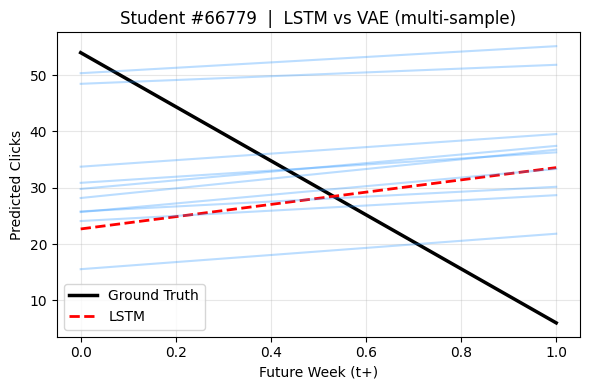

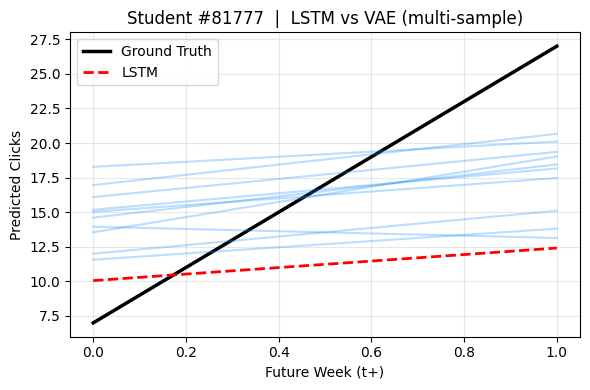

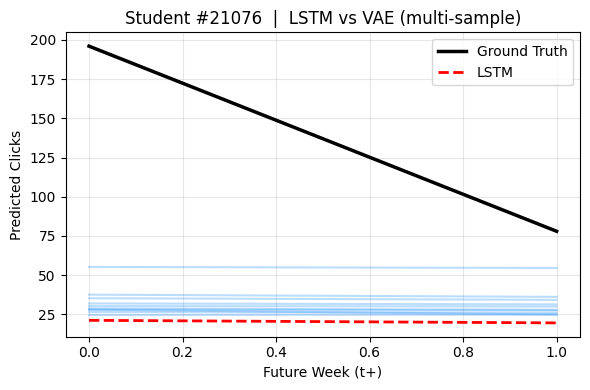

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# ============================================================
# üé® ÂèØË¶ñÂåñÔºöLSTM vs VAEÔºàÂ§öÊ®£ÁîüÊàêÊØîËºÉÔºâ
# ============================================================

def plot_comparison(lstm_pred, vae_samples, y_true, n_examples=3, n_vae_to_show=10):
    """
    üîπ ÂäüËÉΩÔºö
        Âú®Âêå‰∏ÄÂºµÂúñ‰∏≠ÊØîËºÉÔºö
          - Ground TruthÔºàÁúüÂØ¶Êú™‰æÜ clicksÔºâ
          - LSTM È†êÊ∏¨ÔºàÂñÆ‰∏ÄË∑ØÂæëÔºâ
          - VAE Â§öÊ¢ùÈö®Ê©üÁîüÊàêÊ®£Êú¨

    üîπ Ëº∏ÂÖ•ÂèÉÊï∏Ôºö
        lstm_pred       : Tensor (B, T_OUT, 1)ÔºåLSTM È†êÊ∏¨ÁµêÊûú
        vae_samples     : list of TensorÔºåÊØèÂÄãÂÖÉÁ¥†ÁÇ∫ (B, T_OUT, 1)
        y_true          : Tensor (B, T_OUT, 1)ÔºåÁúüÂØ¶Ê®ôÁ±§
        n_examples      : Ë¶ÅÈö®Ê©üÈ°ØÁ§∫ÁöÑÂ≠∏ÁîüÊ®£Êú¨Êï∏
        n_vae_to_show   : ÊØè‰ΩçÂ≠∏ÁîüÈ°ØÁ§∫ÂπæÊ¢ù VAE Êõ≤Á∑öÔºàÂèØË¶ñÂåñÂ§™Â§öÊúÉÈõú‰∫ÇÔºâ

    üîπ ÂúñÂÉèÈ°èËâ≤Á¥ÑÂÆöÔºö
        - ÈªëÁ∑ö (k-)      ‚Üí Ground TruthÔºàÁúüÂØ¶ clicksÔºâ
        - Á¥ÖËôõÁ∑ö (r--)   ‚Üí LSTM ÂñÆ‰∏ÄË∑ØÂæëÈ†êÊ∏¨
        - Ê∑∫ËóçÁ∑ö (dodgerblue, Œ±=0.3) ‚Üí Â§öÊ¢ù VAE ÁîüÊàêÊõ≤Á∑ö
    """
    B = lstm_pred.size(0)
    # Èö®Ê©üÊåëÈÅ∏ n_examples ‰ΩçÂ≠∏Áîü
    idxs = random.sample(range(B), n_examples)

    for i, idx in enumerate(idxs, 1):
        # ÂèñÂá∫Ë©≤Â≠∏ÁîüÁöÑÁúüÂØ¶Â∫èÂàóËàáÈ†êÊ∏¨ÁµêÊûú
        gt = y_true[idx].cpu().numpy().flatten()       # ÁúüÂØ¶ÂÄº
        lstm_y = lstm_pred[idx].cpu().numpy().flatten() # LSTM È†êÊ∏¨

        plt.figure(figsize=(6, 4))

        # --- Ground TruthÔºàÈªëÂØ¶Á∑öÔºâ ---
        plt.plot(range(T_OUT), gt, 'k-', lw=2.5, label="Ground Truth")

        # --- LSTM ÂñÆ‰∏ÄË∑ØÂæëÔºàÁ¥ÖËôõÁ∑öÔºâ ---
        plt.plot(range(T_OUT), lstm_y, 'r--', lw=2.0, label="LSTM")

        # --- VAE Â§öÊ®£ÁîüÊàêÊ®£Êú¨ÔºàËóçËâ≤ÈÄèÊòéÁ∑öÔºâ ---
        for k in range(min(n_vae_to_show, len(vae_samples))):
            yk = vae_samples[k][idx].cpu().numpy().flatten()
            plt.plot(range(T_OUT), yk, color='dodgerblue', alpha=0.3)

        # --- Ë¶ñË¶∫‰øÆÈ£æ ---
        plt.title(f"Student #{idx}  |  LSTM vs VAE (multi-sample)")
        plt.xlabel("Future Week (t+)")
        plt.ylabel("Predicted Clicks")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


# ============================================================
# üß™ ÁØÑ‰æãÂü∑Ë°å
# ============================================================

plot_comparison(lstm_pred, vae_samples, y_true2, n_examples=3, n_vae_to_show=10)


In [ ]:
import torch
import pandas as pd
import numpy as np

# ============================================================
# üßÆ 1) Ê∫ñÂÇôË≥áÊñôÂºµÈáèÔºàÁµ±‰∏ÄÂú® CPUÔºâ
# ============================================================
# Ë™™ÊòéÔºö
# - Êää LSTM / VAE / Ground Truth ÈÉΩËΩâÊàê CPU ÂºµÈáèÔºåÊñπ‰æøÂæåÁ∫åÁî® numpy/pandas ÂàÜÊûê„ÄÇ
# - y_true2 ÊòØÊ∏¨Ë©¶ÈõÜÁöÑÁúüÂØ¶ clicks„ÄÇ

y_true = y_true2  # Ëã•ËÆäÊï∏ÂêçÁ®±‰∏çÂêåÔºåÊîπÊàê y_true2
P_lstm = lstm_pred.detach().cpu()     # (B, T_OUT, 1) ‚Üí LSTM È†êÊ∏¨
Y_true = y_true.detach().cpu()        # (B, T_OUT, 1) ‚Üí ÁúüÂØ¶ÂÄº
S_vae  = torch.stack(vae_samples, dim=0).detach().cpu()  # (N, B, T_OUT, 1) ‚Üí N Ê¢ù VAE Ê®£Êú¨

B = P_lstm.size(0)  # Â≠∏ÁîüÊï∏Èáè
N = S_vae.size(0)   # VAE ÁîüÊàêÊ®£Êú¨Êï∏


# ============================================================
# üßæ 2) ÊØè‰ΩçÂ≠∏ÁîüÁöÑ MSEÔºàÂéüÂßãÂ∞∫Â∫¶Ôºâ
# ============================================================
# ÂäüËÉΩÔºöË®àÁÆóÊØè‰ΩçÂ≠∏ÁîüÁöÑÈ†êÊ∏¨Ë™§Â∑ÆÔºàLSTM vs VAEÔºâ
# - LSTMÔºöÂñÆ‰∏ÄË∑ØÂæëÁöÑÂπ≥ÂùáÂπ≥ÊñπË™§Â∑Æ
# - VAEÔºöN Ê¢ùÊ®£Êú¨ÂàÜÂà•Ë®àÁÆó MSEÔºåÊåëÊúÄÂ•ΩÁöÑÈÇ£Ê¢ù (Best-of-N)

mse_seq_lstm = ((P_lstm - Y_true) ** 2).mean(dim=(1, 2))                  # (B,)
mse_seq_vae_all = ((S_vae - Y_true.unsqueeze(0)) ** 2).mean(dim=(2, 3))   # (N, B)

# Â∞çÊØè‰ΩçÂ≠∏ÁîüÂèñÂá∫ VAE ÊúÄ‰Ω≥Ê®£Êú¨ÔºàMSE ÊúÄÂ∞èÔºâ
best_vals, best_idx = torch.min(mse_seq_vae_all, dim=0)  # (B,), (B,)
# Œî = LSTM - VAE_bestÔºàÊ≠£ÂÄº‰ª£Ë°® VAE ËºÉÊ∫ñÔºâ
delta = mse_seq_lstm - best_vals


# ============================================================
# üåà 3) ÊØè‰ΩçÂ≠∏ÁîüÁöÑÂ§öÊ®£ÊÄßÔºàDiversityÔºâ
# ============================================================
# ÂÆöÁæ©ÔºöVAE Âú®Ë©≤Â≠∏Áîü‰∏äÁöÑÁîüÊàêÂ∫èÂàó‰πãÊ®ôÊ∫ñÂ∑ÆÔºà‰ª£Ë°®‰∏çÁ¢∫ÂÆöÊÄßÔºâ
# Ë®àÁÆóÔºöÂú®Ê®£Êú¨Á∂≠Â∫¶‰∏äÂèñ stdÔºåÂÜçÂ∞çÊôÇÈñìËàáÈÄöÈÅìÂπ≥Âùá„ÄÇ
# ÁµêÊûúÔºöÊØè‰ΩçÂ≠∏Áîü‰∏ÄÂÄã scalarÔºåË∂äÂ§ß‰ª£Ë°®Â§öÊ®£ÊÄßË∂äÈ´ò„ÄÇ

div_seq = S_vae.std(dim=0).mean(dim=(1, 2))  # (B,)


# ============================================================
# üîç 4) ÂåπÈÖçÊØè‰ΩçÂ≠∏ÁîüÁöÑÁúüÂØ¶ / LSTM / VAE_best Â∫èÂàó
# ============================================================
# ‰æùÁÖß best_idx ÊääÊØè‰ΩçÂ≠∏ÁîüÁöÑÊúÄ‰Ω≥ VAE È†êÊ∏¨ÂèñÂá∫„ÄÇ
# Êñπ‰æøÂæåÁ∫åÊ™¢Ë¶ñÂÖ∑È´î‰æãÂ≠êÔºà‰æãÂ¶Ç Top-5 ÊîπÂñÑÊàñÈÄÄÊ≠•Ôºâ„ÄÇ

arange_B = torch.arange(B)
y_vae_best = S_vae[best_idx, arange_B, :, :]  # (B, T_OUT, 1)

# Â∞áÊØèÊ¢ùÂ∫èÂàóËΩâÊàê list Ê†ºÂºèÔºà‰æøÊñºËº∏Âá∫Êàñ DataFrame Â≠òÊîæÔºâ
def row_to_list(x):
    return [float(v) for v in x.view(-1).tolist()]

rows = []
for i in range(B):
    rows.append({
        "idx":          int(i),
        "LSTM_MSE":     float(mse_seq_lstm[i].item()),
        "VAE_best_MSE": float(best_vals[i].item()),
        "Œî(LSTM‚àíVAE)":  float(delta[i].item()),       # ÊîπÂñÑÈáèÔºàÊ≠£ÂÄºË°®Á§∫ VAE ÂãùÂá∫Ôºâ
        "y_true":       row_to_list(Y_true[i]),
        "y_LSTM":       row_to_list(P_lstm[i]),
        "y_VAE_best":   row_to_list(y_vae_best[i]),
        "Diversity_std": float(div_seq[i].item()),
    })

df = pd.DataFrame(rows)


# ============================================================
# ‚ö†Ô∏è 5) Top-5 ÈÄÄÊ≠•Ê°à‰æãÔºàVAE ÊØî LSTM Â∑ÆÔºâ
# ============================================================
# Âæû Œî(LSTM‚àíVAE) ÂèñÊúÄÂ∞èÁöÑ‰∫îÁ≠ÜÔºàÂç≥ VAE È†êÊ∏¨ÊúÄÁ≥üÁöÑÂ≠∏ÁîüÔºâ

top5_regressed = df.nsmallest(5, "Œî(LSTM‚àíVAE)")
print("=== Top-5 RegressedÔºàVAE best >> LSTMÔºâ===")
display(top5_regressed)


# ============================================================
# üìä 6) ‰æù Œî ÂàÜÊ°∂ÔºàWin-rate by Improvement BucketÔºâ
# ============================================================
# ÂäüËÉΩÔºöÂ∞áÊâÄÊúâÂ≠∏Áîü‰æùÊìö Œî ÂÄºÂàÜÁæ§ÔºåÁµ±Ë®à VAE ÊîπÂñÑÁ®ãÂ∫¶ÂàÜÂ∏É„ÄÇ
# Ë™™ÊòéÔºö
# - Œî = LSTM MSE ‚àí VAE best MSE
# - Ëã• Œî > 0 ‚Üí ‰ª£Ë°® VAE ÊØî LSTM Ê∫ñÔºàÊ≠£ÂÄºË∂äÂ§ßÊîπÂñÑË∂äÂ§öÔºâ
# - Ëã• Œî < 0 ‚Üí ‰ª£Ë°® VAE ÊØî LSTM Â∑Æ

bins = [-np.inf, -1000, -200, -50, -10, 10, 50, 200, 1000, np.inf]  # ÂàÜÊ°∂ÈÇäÁïå
labels = [
    "VAE<<Âä£(‚â™-1000)",
    "VAEÂä£(200~1000)",
    "VAEÂä£(50~200)",
    "VAEÂä£(10~50)",
    "‚âàÊâìÂπ≥(¬±10)",
    "VAEÁï•Âãù(10~50)",
    "VAEÂãù(50~200)",
    "VAEÂ§ßÂãù(200~1000)",
    "VAE>>Â§ßÂãù(‚â´1000)"
]

# Â∞ç Œî ÂÄºÂàÜÊ°∂
bucket = pd.cut(df["Œî(LSTM‚àíVAE)"], bins=bins, labels=labels, right=True)

# Áµ±Ë®àÊØèÂÄãÂçÄÈñìÁöÑÊ®£Êú¨Êï∏ËàáÊØî‰æã
table = (
    bucket.value_counts()
    .reindex(labels)
    .fillna(0)
    .astype(int)
    .rename("count")
    .to_frame()
)
table["ratio"] = (table["count"] / len(df)).round(4)

print("\n=== Win-rate by improvement bucketÔºàŒî = LSTM MSE ‚àí VAE best MSEÔºâ ===")
display(table)


=== Top-5 RegressedÔºàVAE best >> LSTMÔºâ===


idx      LSTM_MSE  VAE_best_MSE  Œî(LSTM‚àíVAE)  \
53195  53195  3.002442e+06  3.586380e+06 -583938.7500   
53194  53194  4.025990e+06  4.475906e+06 -449915.5000   
31808  31808  1.267695e+06  1.369916e+06 -102220.2500   
12315  12315  1.530183e+05  2.433338e+05  -90315.4375   
53193  53193  1.856512e+06  1.939039e+06  -82526.5000   

                                         y_true  \
53195              [3115.0, 1309.9998779296875]   
53194              [1872.9998779296875, 3115.0]   
31808                            [2112.0, 64.0]   
12315               [1064.0, 781.9999389648438]   
53193  [1271.9998779296875, 1872.9998779296875]   

                                         y_LSTM  \
53195    [770.5662231445312, 596.8987426757812]   
53194    [685.7081909179688, 537.7301635742188]   
31808    [579.0489501953125, 494.6407470703125]   
12315     [579.175048828125, 515.5765380859375]   
53193  [222.31646728515625, 257.08221435546875]   

                                    y_VAE_best  Diversity_std  
53195       [565.771484375, 488.9063415527344]       6.056210  
53194  [513.9844970703125, 449.50030517578125]       9.820096  
31808   [502.2989807128906, 449.6079406738281]      10.577400  
12315  [467.0916748046875, 420.93487548828125]      10.640914  
53193  [209.9903564453125, 214.62301635742188]       4.180231


=== Win-rate by improvement bucketÔºàŒî = LSTM MSE ‚àí VAE best MSEÔºâ ===


count   ratio
Œî(LSTM‚àíVAE)                   
VAE<<Âä£(‚â™-1000)     648  0.0071
VAEÂä£(200~1000)    1911  0.0209
VAEÂä£(50~200)      4709  0.0514
VAEÂä£(10~50)       4963  0.0542
‚âàÊâìÂπ≥(¬±10)          4507  0.0492
VAEÁï•Âãù(10~50)      8980  0.0981
VAEÂãù(50~200)     17641  0.1927
VAEÂ§ßÂãù(200~1000)  28645  0.3128
VAE>>Â§ßÂãù(‚â´1000)   19562  0.2136